# 0.0. IMPORTS

In [4]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import pathlib
import seaborn as sns
import ast
import lightgbm as lgb
import xgboost as xgb
from scipy.stats       import chi2_contingency
from category_encoders import TargetEncoder
from sklearn          import preprocessing as pp
import pickle
import os
import folium
import featuretools as ft
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing    import OrdinalEncoder
from folium.plugins           import HeatMap
from matplotlib.pyplot        import plot as plt
from xgboost                  import XGBRegressor
from lightgbm                 import LGBMRegressor
from geopy.geocoders          import Nominatim
from sqlalchemy               import create_engine, text
from matplotlib               import pyplot as plt
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestRegressor
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression,  Lasso
from sklearn.metrics          import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,r2_score
from sklearn.model_selection  import cross_val_score
from sklearn.preprocessing    import LabelEncoder
from sklearn.model_selection  import KFold

## 0.1.0 Helper Functions

In [5]:
# função para consultar a api passando as coordenadas
def find_mun( lat,long ):
    
    geolocator = Nominatim(user_agent="Oscar")
    
    lat = str( lat )
    
    long = str( long )
    
    coord = lat + ',' + long

    location = geolocator.reverse( coord  )
    
    if 'city_district' in location.raw['address']:
        
        return location.raw['address']['city_district']
        
    if 'suburb' in location.raw['address']:
            
        return location.raw['address']['suburb']
            
    if 'county' in location.raw['address']:
            
        return location.raw['address']['county']
        
    else:
        
        return 'not found'

  
def stats( df , excepto = [] ):
    # separo as feautures numéricas
    if excepto != "":
    
        num_attributes = df.select_dtypes( include = ['int64','float64'] )
        
        num_attributes = num_attributes.drop( excepto , axis = 1 ) 
        
    else:
        
        num_attributes = df.select_dtypes( include = ['int64','float64'] )
    # separo as features categoricas
    num_categorical = df.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )


    # medidas de tendencia central - media e mediana
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # media

    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T # mediana

    # dispersao - std, min , max , range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # std
    d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # minimo
    d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # maximo
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T # range
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T # skew
    d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() ) ).T # kurtosis

    # concatenate - min , max , range,  media, median, std, skew , kurtosis
    m = pd.concat( [ d2 , d3, d4 , ct1 , ct2 , d1,  d5 , d6 ] ).T.reset_index()
    m.columns = [ 'features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
    pd.set_option( 'display.float_format', '{:,.2f}'.format )
    return m

def ml_error( model_name, y , y_hat):
    mae =  mean_absolute_error( y , y_hat )
    mape = mean_absolute_percentage_error( y , y_hat )
    rmse = np.sqrt( mean_squared_error( y , y_hat ) )
    r2 =   r2_score(y, y_hat)
    df = pd.DataFrame( {'Model Name ' :  model_name,
                        'MAE' : mae ,
                        'MAPE' : mape,
                        'RMSE' : rmse,
                        'R2_score' : r2  } ,index = [0] )
    
    return df

def remover_outliers( df, coluna ):
    
    linhas_iniciais = df.shape[0] 
    
    
    d1 = df[coluna].quantile(0.25)
    d3 = df[coluna].quantile(0.75)

    lim_superior = d3 + 1.5*( d3 - d1  )

    lim_inferior = d1 - 1.5 * ( d3 - d1 )
    
    
    df = df.loc[ (df[coluna] >= lim_inferior) & (df[coluna] <= lim_superior) , :  ]
    
    linhas_finais = df.shape[0]
    
    
    print('Foram removidas {} linhas'.format( linhas_iniciais - linhas_finais ) )
          
    return df

def cramer_v( x, y ):
    cm = pd.crosstab( x , y ).values

    n = cm.sum()

    r,k = cm.shape

    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1) * (r-1) / (n-1) ) # chi2 corrigido
    kcorr = k - (k-1)**2 / (n-1) # k corrigido
    rcorr = r - (k-1)**2 / (n-1) # r corrigido
    
    v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
    
    return v

In [6]:
class Idealista:
    def __init__( self ):
        
        self.df_region = pd.read_csv( 'datasets/df_region.csv' )
        self.home_path                    = r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings'

        self.te_status                    = pickle.load(open(os.path.join(self.home_path, 'te_status.pkl'), 'rb'))
        self.te_province                  = pickle.load(open(os.path.join(self.home_path,'te_province.pkl') , 'rb'))
        self.te_property_type             = pickle.load(open(os.path.join(self.home_path,'te_property_type.pkl'), 'rb'))
        self.te_municipality              = pickle.load(open(os.path.join(self.home_path,'te_municipality.pkl'), 'rb' ))
        self.te_district                  = pickle.load(open(os.path.join(self.home_path,'te_district.pkl'),'rb'))
        self.le_detailed_type             = pickle.load(open(os.path.join(self.home_path,'le_detailed_type.pkl'),'rb' ))
        self.freq_encoding_address        = pickle.load(open(os.path.join(self.home_path,'freq_encoding_address.pkl'), 'rb' ))
        self.bathrooms_bin                = pickle.load(open(os.path.join(self.home_path,'bathrooms_bin.pkl'), 'rb' ))
        self.bathrooms_bin                = pickle.load(open(os.path.join(self.home_path,'bathrooms_bin.pkl'), 'rb' ))

        
    
    
    
    def transform_data(self, df, colunas_irrelevantes ):

        cols_old = df.columns.to_list()

        # def função snake_case
        snake_case = lambda x: inflection.underscore( x )

        # defino as novas colunas
        cols_new = list(map( snake_case, cols_old )) 

        # atribuo as novas colunas ao df
        df.columns = cols_new

        # removo as linhas em branco que possam ter vindo na extração
        df = df.loc[~ df['property_code'].isna() , : ]

        # removo duplicadas
        df = df.drop_duplicates( subset= ['property_code'], keep = 'last' )

        # preencho os vazios
        df = fill_na( df )

        # deleto as colunaas irrelevantes
        df = delete_columns( df , colunas_irrelevantes )
   
        return df


#=======================================================================================================================#

    def feature_engineering(self, df , transform_data = False, merge_datasets = False   ):
        
        if transform_data == True and merge_datasets == False :
            
            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            print( 'Dados Transformados' )

            return df
        
    
        if merge_datasets == True and transform_data == False:
        
            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

#======================================================================================================================#

            # calculando a média por 'province'
            df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

            # exportando para csv
            # df2_province_mean_price.to_csv( 'datasets/province.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'Datasets combinados com preços regioes' )

            return df
    
        if transform_data == True and merge_datasets == True:

            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

    # ======================================================================================================================#

            # calculando a média por 'province'
            df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

            # exportando para csv
            # df2_province_mean_price.to_csv( 'datasets/province.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'datasets combinados e dados transformados' )
        
            return df
        
        else:

            print( 'Nenhuma Transformação' )

            return df
            
#=======================================================================================================================#
    
    def filter_variables(self, df, filter_variables = False):
    
        if filter_variables:

            # Vou querer saber somente os preços na province de Lisboa
            df = df.loc[ df['province'] == 'Lisboa' , :  ]

            # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
            df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]

            print('Variavies filtradas')

            return df

        else:

            print('Variavies não filtradas')

            return df

#=======================================================================================================================#

    # função para remover outliers
    def remove_outliers(self, df, coluna = None ,  keep_outliers = True ):

        if keep_outliers:
            print( 'Outliers mantidos' )
            return df

        else:
            # variavel resposta sem outliers
            df = remover_outliers( df4 , coluna )
            print('Outliers removidos')
            return df

#=======================================================================================================================#
    
    def rescaling_data(self, df, rescale = False ):

        if rescale:
            rs = RobustScaler() # robusto com outliers
            mms = pp.MinMaxScaler() # desvio padrão pequeno e quando não ha distribuição gaussiana

    #         # num_photos
    #         rs_num_photos = RobustScaler() 
    #         # num_photos
    #         df['num_photos'] = rs_num_photos.fit_transform( df[['num_photos']].values )

            # floor
#             rs_floor = RobustScaler() 
#             # num_photos
#             df['floor'] = rs_floor.fit_transform( df[['floor']].values )

            # size
            rs_size = RobustScaler() 
            # size
            df['size'] = rs_size.fit_transform( df[['size']].values )

            # rooms
    #         mms_rooms = pp.MinMaxScaler() 
    #         # rooms
    #         df['rooms'] = mms_rooms.fit_transform( df[['rooms']].values )

            # bathrooms
    #         rs_bathrooms = RobustScaler() 
    #         # bathrooms
    #         df['bathrooms'] = rs_bathrooms.fit_transform( df[['bathrooms']].values )

            # distance
            rs_distance = RobustScaler()
            # distance
            df['distance'] = rs_distance.fit_transform( df[['distance']].values )



            print('Rescaled')

            return  df
        else:
            print('Not rescaled')

            return df

#=======================================================================================================================#

    def encoding(self,  df ):

        # floor
        floor_mapping = {
            'ss': -1,   # subsolo
            'bj': 0,    # térreo
            'en': 0.5,  # entrepiso ou mezanino, considerado entre o térreo e o primeiro andar
            'st': 1.5   # sótão ou andar superior, considerado entre o primeiro andar e um segundo hipotético
        }

        df['floor'] = df['floor'].replace( floor_mapping ).astype( int )

        #property_type - label
        te_property_type = {'flat' : 0, 'duplex' : 1, 'chalet' : 2, 'studio': 3, 'penthouse': 4, 'countryHouse':5}
        #te_property_type = df.groupby( 'property_type' )['price'].mean()
        df['property_type'] = df['property_type'].map( te_property_type )
        pickle.dump(te_property_type,open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_property_type.pkl', 'wb' ) )

        # address - label
        freq_encoding_address = df['address'].value_counts(normalize=True)
        df['address'] = df['address'].map( freq_encoding_address )
        pickle.dump( freq_encoding_address, open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\freq_encoding_address.pkl', 'wb') )

        # province 
        te_province = df['province'].value_counts( )
        #te_province = df.groupby( 'province' )['price'].mean()
        df['province'] = df['province'].map( te_province )
        pickle.dump( te_province, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_province.pkl', 'wb' ) )

#         # municipality - label
#         te_municipality = df['municipality'].value_counts()
#         #te_municipality = df.groupby( 'municipality' )['price'].mean()
#         df['municipality'] = df['municipality'].map( te_municipality ).astype( 'float64' )
#         pickle.dump( te_municipality, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_municipality.pkl', 'wb' ) )            

        # municipality
    #     freq_encoding_municipality = df['municipality'].value_counts(normalize=True)
    #     df['municipality'] = df['municipality'].map( freq_encoding_municipality )


        # district - label
        te_district = df['district'].value_counts()
        #te_district = df.groupby( 'district' )['price'].mean()
        df['district'] = df['district'].map( te_district ).astype( 'float64' )
        pickle.dump( te_district, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_district.pkl', 'wb' ) )  
        # district
    #     freq_encoding_district = df['district'].value_counts(normalize=True)
    #     df['district'] = df['district'].map( freq_encoding_district )


        # Show address
        encoding = {True: 1 , False: 0}
        df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

        # description
        df['description'] = df['description'].apply( lambda x : len(x) )

        # has_video
        encoding = {True: 1 , False: 0}
        df['has_video'] = df['has_video'].map( encoding )

        # status
        te_status = {'good' : 1, 'newdevelopment' : 2 , 'renew' : 3}
        #te_status = df.groupby( 'status' )['price'].mean()
        df['status'] = df['status'].map( te_status ).astype( 'float64' )
        pickle.dump( te_status, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_status.pkl', 'wb' ) )  

        # label encoder status
        #status_encoder = LabelEncoder()
        #df['status'] = status_encoder.fit_transform( df['status'] )

        # new_development
        encoding = {True: 1 , False: 0}
        df['new_development'] = df['new_development'].map( encoding )

#         # detailed type - label
#         le_detailed_type = LabelEncoder()

#         df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
#         df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
#         df['detailed_type'] = le_detailed_type.fit_transform( df['detailed_type'] )
#         pickle.dump( le_detailed_type, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\le_detailed_type.pkl', 'wb' ) ) 

        # suggested text
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

        # hasplan
        encoding = {True: 1 , False: 0}
        df['has_plan'] = df['has_plan'].map( encoding )

        # has3_d_tour
        encoding = {True: 1 , False: 0}
        df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

        # has360
        encoding = {True: 1 , False: 0}
        df['has360'] = df['has360'].map( encoding )

        # has_staging
        df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

        # top_new_development
        df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )

        #parking_space
        encoding = {True: 1 , False: 0}
        df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].map( encoding )

#         df = df.drop( 'datetime_scrapy', axis = 1 )

        df = df.fillna(0)

        return df
    
    
    def predicoes(self, df , model ):
        
        # drop price
        X = df.drop( 'price', axis = 1 )
        
        y_hat_final = model.predict( X )
        
        df['pred'] = y_hat_final
        
        return df
        


## 0.2.0. Loading Data

In [7]:
# caminho
caminho = pathlib.Path('data')

df = []

for arquivo in caminho.iterdir():
    print(arquivo.name)
    
    # ler o arquivo
    df_read = pd.read_excel( arquivo )
    
    # apender o df
    df.append(df_read)

# concatena os df's
df_raw = pd.concat( df )

df_raw = df_raw[['propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']]

# resetar index
df_raw = df_raw.reset_index( drop = True )

extracao_12_4_2023.xlsx
extracao_1_1_2023.xlsx
extracao_1_9_2023.xlsx
extracao_26_1_2024.xlsx
extracao_29_2_2024.xlsx
extracao_2_2_2023.xlsx
extracao_2_6_2023.xlsx
extracao_30_3_2024.xlsx
extracao_3_3_2023.xlsx
extracao_6_7_2023.xlsx


## 0.2.1 Separar Dados de Teste

In [8]:
# Separar Dados de Validação
divisor = df_raw.shape[0] - 100
df_val = df_raw.iloc[ divisor: ] # pego 1000 linhas para teste

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [9]:
df1 = df_raw.copy()[:divisor]

## Explicação das colunas

* property_code - ID unico para cada imovel


* thumbnail - mostra a thumbnail do imovel


* external_reference - A feature "external_reference" geralmente se refere a um código único atribuído a um imóvel por outra fonte, como outra plataforma imobiliária ou um agente imobiliário. Essa referência externa pode ser usada para rastrear e identificar o imóvel em diferentes sistemas e plataformas.


* num_photos - número de fotos do anúncio


* price - preço da renda


* property_type - tipo de propriedade


* operation - renda ou venda ( nesse caso tenho somente renda )


* size - tamanho em m2


* exterior - deve ser se o imóvel tem área exterior ( array([ 0., nan]) 


* rooms - quantidade de quartos


* bathrooms - quantidade de casas de banho


* address - endereço do imóvel


* province - são as regiões ( Lisboa, Setúbal, Santarém - vieram na extração )


* municipality - municipios


* district - são os Distritos


* country - PT 


* latitude - latitude


* longitude - longitude


* show_address - boolean - se o anunciante exibe o endereço


* url - a url do anuncio


* distance - distancia do centro em m


* description - descricao do apartamento


* has_video - diz se o anuncio tem vídeo ou não ( array([ 0.,  1., nan]) )


* status - diz sobre o estado do imóvel array(['good', 'renew', 'newdevelopment', None], dtype=object)


* new_development - boolean - diz se o empreendimento é novo ou não 


* price_by_area - preco divido pelo tamanho do imóvel price / size


* detailed_type - descrição detalhada do tipo de imóvel


* suggested_texts - títulos e subtítulos


* has_plan - se o imóvel tem plano ou não


* has3_d_tour - indica se o imóvel tem tour 3d


* has360 - se tem tour 360º


* has_staging - se tem uma decoração na propriedade


* top_new_development - indica os empreendimentos mais novos


* super_top_highlight - indica os imóveis mais valiosos ou populares em uma determinada área


* floor - indica o andar do imóvel


* has_lift - indica se tem elevador


* parking_space - indica se tem vaga de garagem


* neighborhood - Essa feature é útil para compradores e inquilinos que têm preferência por um determinado bairro ou querem morar em uma área específica da cidade por motivos como proximidade do trabalho, escolas, transporte público, entre outros.


* labels - etiquetas ou rótulos associados aos imoveis


* pagina - a pagina da extração ( definida na extração )


* datetime_scrapy - indica a data da extração ( definida na extração )


* newDevelopmentFinished - 


* highlight - 

## 1.1. Rename Columns

In [10]:
cols_old = [ 'propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']

# def função snake_case
snake_case = lambda x: inflection.underscore( x )

# defino as novas colunas
cols_new = list(map( snake_case, cols_old )) 

df1.columns = cols_new

df1 = df1.loc[~ df1['property_code'].isna() , : ]

## 1.1.2 Drop Duplicates

In [11]:
df1 = df1.drop_duplicates( subset= ['property_code'], keep = 'last' )

## 1.2. Data Dimensions

In [12]:
print( 'Number of rows {:,}'.format( df1.shape[0] ) )
print( 'Number of columns {:,}'.format( df1.shape[1] ) )

Number of rows 15,294
Number of columns 43


## 1.3. Data Types

In [13]:
# exibindo os tipos de dados
print( df1.dtypes )

property_code               float64
thumbnail                    object
num_photos                  float64
floor                        object
price                       float64
property_type                object
operation                    object
size                        float64
exterior                     object
rooms                       float64
bathrooms                   float64
address                      object
province                     object
municipality                 object
district                     object
country                      object
latitude                    float64
longitude                   float64
show_address                 object
url                          object
distance                    float64
description                  object
has_video                    object
status                       object
new_development              object
has_lift                    float64
price_by_area               float64
detailed_type               

## 1.4. Check NA

In [14]:
df1.isna().sum()

property_code                   0
thumbnail                      27
num_photos                      0
floor                        6626
price                           0
property_type                   0
operation                       0
size                            0
exterior                     8622
rooms                           0
bathrooms                       0
address                         0
province                        0
municipality                    0
district                     1704
country                         0
latitude                        0
longitude                       0
show_address                    0
url                             0
distance                        0
description                    22
has_video                       0
status                          0
new_development                 0
has_lift                     4668
price_by_area                   0
detailed_type                   0
suggested_texts                 0
has_plan      

In [15]:
# calculando os % de dados vazios
dfna = df1.isna().sum().to_frame().reset_index()
dfna['% dados Vazios'] = ( df1.isna().sum().to_frame().reset_index()[0] / df1.shape[0] ) *100
dfna.loc[ dfna['% dados Vazios'] != 0 , : ]

,index,0,% dados Vazios
1,thumbnail,27,0.176540
3,floor,6626,43.324179
8,exterior,8622,56.375049
14,district,1704,11.141624
21,description,22,0.143847
25,has_lift,4668,30.521773
34,super_top_highlight,7196,47.051131
35,parking_space,10777,70.465542
36,external_reference,2275,14.875114
37,labels,10820,70.746698


## 1.5 - Excluindo colunas irrelevantes

In [16]:
# função para excluir colunas se for passada uma lista
def delete_columns( df , list_columns = None ):
    
    if list_columns is None:
        
        df = df
        
        return df
    
    else:
        
        df = df.drop( list_columns , axis = 1)
        
        return df


In [17]:
# colunas vazias ou irrelevantes
colunas_irrelevantes = [
           'external_reference',
           'labels',
           'neighborhood',
           'new_development_finished',
           'highlight',
           'exterior',
           'super_top_highlight',
           'operation',
           'country',
           'url',
           'price_by_area']

df1 = delete_columns( df1 , colunas_irrelevantes )

## 1.5.1 Fillout NA

In [18]:
def fill_na(df):
    # thumbnail - vou substituir anúncios que possuem thumbnail por 1 e aqueles que não por 0
    df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )

    # floor 
    df.loc[:,'floor'] = df['floor'].apply( lambda x : 0 if pd.isna( x ) else x )

    # district - vou fazer uma chamada na api para procurar os districts passando as coordenadas
    df.loc[:,'district'] = df.apply(lambda x: find_mun( x['latitude'], x['longitude'] ) if pd.isna( x['district'] ) else x['district'],axis = 1)

    # description
    df.loc[:,'description'] = df['description'].apply( lambda x : 'no description' if pd.isna( x ) else x )

    # has_lift - vou considerar que se não foi informado na base o apto imovel não tem elevador
    df.loc[:,'has_lift'] = df['has_lift'].apply( lambda x: 0 if pd.isna( x ) else x  )

    # parking_space 
    df.loc[:,'parking_space'] = df['parking_space'].apply( lambda x: 0 if pd.isna( x ) else x ) 
    
    return df

In [19]:
df1 = fill_na( df1 )

## 1.7. Descriptive Statistical

## 1.7.1 Numerical Attributes

In [20]:
df1_stats = stats( df1 , ['latitude','longitude','pagina'] )
df1_stats


,features,min,max,range,mean,median,std,skew,kurtosis
0,property_code,"27,067,082.00","33,302,910.00","6,235,828.00","32,667,905.76","32,756,182.50","713,507.08",-3.58,17.60
1,num_photos,0.00,180.00,180.00,24.90,23.00,12.91,1.59,5.95
2,price,300.00,"80,000.00","79,700.00","2,797.41","2,000.00","2,683.95",4.99,62.95
3,size,10.00,"30,940.00","30,930.00",139.43,106.00,287.85,84.24,"8,720.25"
4,rooms,0.00,24.00,24.00,2.49,2.00,1.35,1.58,11.93
5,bathrooms,1.00,29.00,28.00,2.01,2.00,1.22,2.54,22.23
6,distance,61.00,"49,855.00","49,794.00","11,052.89","6,618.50","10,273.35",0.84,-0.33
7,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.21,-1.96


## 1.7.2 Categorical Attributes

In [21]:
df1['province'] = df1['province'].apply( lambda x : 'Lisboa' if x == 'lisboa' else 'Setúbal' if x == 'setubal' else 'Santarém' if x == 'santarem'  else x)

num_categorical = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )
# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique().shape[0] ) )

print( '='*100 )

# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique() ) )

thumbnail                  2
floor                     33
property_type              6
address                 5583
province                   3
municipality             143
district                 422
show_address               2
description            14784
has_video                  2
status                     3
new_development            2
detailed_type             15
suggested_texts         6108
has_plan                   2
has3_d_tour                2
has360                     2
has_staging                2
top_new_development        1
parking_space             16
datetime_scrapy          198
dtype: int64
thumbnail                                                         [1, 0]
floor                  [6, 2, bj, 0, 1, 3, 8, 5, 7, en, 16, 4, 11, 9,...
property_type          [flat, chalet, duplex, studio, penthouse, coun...
address                [Nova Carnaxide, Rua Professor Doutor João Bat...
province                                     [Lisboa, Setúbal, Santarém]
municipality 

# 2.0 Feature Engineering

In [22]:
df2 = df1.copy()

In [23]:
df2.head().T

,0,1,2,3,5
property_code,"32,584,112.00","32,584,102.00","32,584,086.00","32,584,074.00","32,583,724.00"
thumbnail,1,1,1,1,1
num_photos,9.00,26.00,32.00,24.00,10.00
floor,6,2,bj,0,0
price,900.00,750.00,"1,500.00",950.00,"1,850.00"
property_type,flat,flat,flat,flat,flat
size,65.00,80.00,64.00,57.00,131.00
rooms,1.00,1.00,1.00,1.00,2.00
bathrooms,1.00,1.00,2.00,1.00,2.00
address,Nova Carnaxide,"Rua Professor Doutor João Batista Machado, 2",Avenida Cidade de Praga,Moscavide e Portela,Rua Professor Noronha Feio


In [24]:
df2.loc[ df2['district'].isin( ['Moscavide e Portela'] ), :]

,property_code,thumbnail,num_photos,floor,price,property_type,size,rooms,bathrooms,address,...,detailed_type,suggested_texts,has_plan,has3_d_tour,has360,has_staging,top_new_development,parking_space,pagina,datetime_scrapy
3,"32,584,074.00",1,24.00,0,950.00,flat,57.00,1.00,1.00,Moscavide e Portela,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",0.00,0.00,0.00,0.00,0.00,0,1.00,2023-04-12 22:00:03
530,"32,536,179.00",1,25.00,10,"1,950.00",flat,151.00,4.00,2.00,Moscavide e Portela,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",0.00,0.00,0.00,0.00,0.00,0,11.00,2023-04-12 22:00:06
832,"32,552,829.00",1,21.00,0,"1,500.00",flat,123.00,3.00,2.00,Moscavide e Portela,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",1.00,0.00,0.00,0.00,0.00,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",18.00,2023-04-12 22:00:09
953,"32,532,817.00",1,41.00,0,"1,550.00",flat,149.00,3.00,2.00,Rua Amélia Rey Colaço s/n,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",0.00,0.00,0.00,0.00,0.00,0,20.00,2023-04-12 22:00:10
956,"32,548,939.00",1,24.00,0,"1,150.00",flat,69.00,3.00,1.00,Rua Artur Ferreira da Silva s/n,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",0.00,0.00,0.00,0.00,0.00,0,20.00,2023-04-12 22:00:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26835,"32,737,234.00",1,8.00,7,"2,500.00",flat,172.00,4.00,2.00,"Rua Vasco Santana, 7",...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",1.00,0.00,0.00,0.00,0.00,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",28.00,2023-07-06 10:18:44
27018,"32,571,552.00",1,20.00,1,"1,200.00",flat,57.00,2.00,1.00,Moscavide e Portela,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",0.00,0.00,0.00,0.00,0.00,0,32.00,2023-07-06 10:18:45
27020,"32,659,064.00",1,17.00,1,"1,050.00",flat,50.00,1.00,1.00,Moscavide e Portela,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",0.00,0.00,0.00,0.00,0.00,0,32.00,2023-07-06 10:18:45
27326,"32,733,725.00",1,29.00,0,"1,600.00",flat,146.00,3.00,2.00,Moscavide e Portela,...,{'typology': 'flat'},"{'subtitle': 'Moscavide e Portela, Loures', 't...",0.00,0.00,0.00,0.00,0.00,0,39.00,2023-07-06 10:18:47


## 2.1 - Razões

In [25]:
# m2_n_photos
df2 = df2.loc[ df2['num_photos'] > 0 , : ] 
df2['m2/n_photos'] = df2['size'] / df2['num_photos']

# m2_rooms
df2 = df2.loc[ df2['rooms'] > 0 , : ]
df2['m2/n_rooms'] = df2['size'] / df2['rooms']

# size by bathorooms
df2['size_by_rooms'] = df2['size'] / df2['bathrooms']

# desvio_mean_price
df2_size_province = df2[['province','size']].groupby( 'province' ).mean().reset_index().rename( columns = {'size': 'province_mean_size'} )
df2 = pd.merge( df2, df2_size_province, how = 'left', on = 'province' )
df2['desvio_do_m2_medio'] = df2['size'] - df2['province_mean_size']

# len descprtion by size
df2['description_by_size'] = df2.apply( lambda x: x['size'] / len(x['description']), axis = 1 )

# mean_price/size
aux = df2[['province','price']].groupby( 'province' ).mean().reset_index()
mean_price = aux['price'].mean()
df2['size_by_mean_province'] = mean_price / df2['size']

# num photos by rooms
df2['num_photos_by_rooms'] = df2['rooms'] / df2['num_photos']

# mean by property type

In [26]:
df_grouped = df2[['property_type','price','district']].groupby( ['property_type', 'district'] )
df_aux = df_grouped.median().reset_index()
df_aux[ df_aux['district'] == 'Moscavide e Portela' ]

,property_type,district,price
324,duplex,Moscavide e Portela,"13,000.00"
593,flat,Moscavide e Portela,"1,500.00"


## 2.2 - Datas

In [27]:
# month
df2['month'] = pd.to_datetime( df2['datetime_scrapy'] ).dt.month

# year
df2['year'] = pd.to_datetime( df2['datetime_scrapy'] ).dt.year

## 2.3 - Médias

In [28]:
# mean price by municipality 
df_municipality = df2[['municipality','price']].groupby( 'municipality' ).mean().reset_index().rename( columns = {'price': 'municipality_mean_price'} )
df2 = pd.merge( df2, df_municipality, how = 'left', on = 'municipality' )

# municipality by district
df_district = df2[['district','price']].groupby( 'district' ).mean().reset_index().rename( columns = {'price': 'district_mean_price'} )
df2 = pd.merge( df2 , df_district, how = 'left', on = 'district' )

# municipality mean size
df2_municipality_mean_size = df2[['municipality','size']].groupby( 'municipality' ).mean().reset_index().rename( columns = {'size': 'municipality_size'} )
df2 = pd.merge( df2, df2_municipality_mean_size, how = 'left', on = 'municipality' )

# district mean size
df2_district_size = df2[['district','size']].groupby( 'district' ).mean().reset_index().rename( columns = {'size': 'district_mean_size'} )
df2 = pd.merge( df2, df2_district_size, how = 'left', on = 'district' )

# province mean price
df_province = df2[['province','price']].groupby( 'province' ).mean().reset_index().rename( columns = {'price': 'province_mean_price'} )
df2 = pd.merge( df2, df_province, how = 'left', on = 'province' )

In [29]:
# Primeiro, agrupe o DataFrame por 'province'
grouped = df2.groupby(['province','rooms'])

# Agora, aplique as funções de agregação ao grupo
aux = grouped.agg(
    n_quartos=('rooms', 'sum'),       # Conta o número de entradas (quartos) por província
    preco_total=('province_mean_price', 'sum')  # Soma o preço médio por província
)
aux['media_quartos'] = aux['preco_total'] / aux['n_quartos']
aux

n_quartos   preco_total  media_quartos
province rooms                                        
Lisboa   1.00    2,627.00  7,767,544.30       2,956.81
         2.00    9,186.00 13,580,636.07       1,478.41
         3.00   10,674.00 10,520,335.97         985.60
         4.00    6,532.00  4,828,473.48         739.20
         5.00    2,490.00  1,472,492.22         591.36
         6.00    1,350.00    665,282.63         492.80
         7.00      546.00    230,631.31         422.40
         8.00      168.00     62,093.05         369.60
         9.00      126.00     41,395.36         328.53
         10.00      60.00     17,740.87         295.68
         11.00      66.00     17,740.87         268.80
         12.00      12.00      2,956.81         246.40
         13.00      13.00      2,956.81         227.45
         19.00      19.00      2,956.81         155.62
         20.00      20.00      2,956.81         147.84
         21.00      21.00      2,956.81         140.80
         24.00      24.00      2,956.81         123.20
Santarém 1.00        4.00      9,008.57       2,252.14
         2.00        2.00      2,252.14       1,126.07
         3.00       12.00      9,008.57         750.71
         4.00       12.00      6,756.43         563.04
         5.00       10.00      4,504.29         450.43
Setúbal  1.00      233.00    441,593.79       1,895.25
         2.00      948.00    898,349.60         947.63
         3.00    1,539.00    972,264.45         631.75
         4.00      708.00    335,459.66         473.81
         5.00      395.00    149,724.93         379.05
         6.00      108.00     34,114.54         315.88
         7.00       21.00      5,685.76         270.75
         8.00       16.00      3,790.50         236.91
         9.00       18.00      3,790.50         210.58
         10.00      10.00      1,895.25         189.53

# 3.0 Filtragem de Variáveis

In [30]:
df3 = df2.copy()

In [31]:
def filter_variables(df, filter_variables = False):
    
    if filter_variables:
        
        # Vou querer saber somente os preços na province de Lisboa
        df = df.loc[ df['province'] == 'Lisboa' , :  ]

        # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
        df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]
        
        print('Variavies filtradas')
        
        return df
    
    else:
        
        print('Variavies não filtradas')
        
        return df

        
    

In [32]:
# vou manter filter_variables = False neste ciclo
df3 = filter_variables( df3 )

Variavies não filtradas


# 4.0 Análise Exploratória de Dados

In [33]:
df4 = df3.copy()

## 4.1. - Analise Univariada

### Thumbnail

In [34]:
# imoveis por thumbnais
df_aux = ( df4[['thumbnail','price']].groupby( 'thumbnail').agg(
        n_amostras = ( 'thumbnail' ,'count' ),
        preco_medio = ('price', 'mean')

) ).reset_index() 

df_aux['% de amostras'] = df4['thumbnail'].value_counts( normalize= True )
df_aux

,thumbnail,n_amostras,preco_medio,% de amostras
0,1,14781,"2,848.27",NaN


* Observação : Poucos imóveis não tem thumbnail no anúncio, ou seja a maioria dos imóveis tem thumbnail. O preço médio não tem muita relação com o fato de ter ou não thumbnail

### num_photos

<Axes: xlabel='num_photos', ylabel='price'>

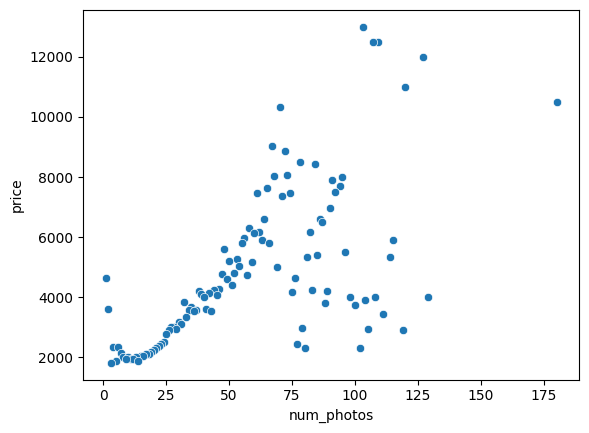

In [35]:
# imóveis por número de fotos
df_aux = df4[['num_photos','price']].groupby( 'num_photos' ).mean().reset_index().sort_values( 'price', ascending = False )

sns.scatterplot( x = 'num_photos', y = 'price', data = df_aux)


* Observação: Quanto maior o número de fotos, maior o preço médio dos imóveis ( para a maioria dos casos parece haver uma tendência ).

### floor

<Axes: xlabel='floor', ylabel='price'>

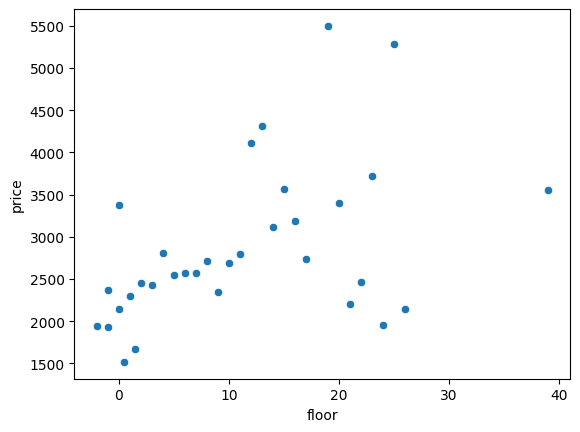

In [36]:
# floor
df_aux = df4[['floor','price']].groupby( 'floor' ).mean().reset_index()

floor_mapping = {
    'ss': -1,   # subsolo
    'bj': 0,    # térreo
    'en': 0.5,  # entrepiso ou mezanino, considerado entre o térreo e o primeiro andar
    'st': 1.5   # sótão ou andar superior, considerado entre o primeiro andar e um segundo hipotético
}

df_aux['floor'] = df_aux['floor'].replace( floor_mapping ) 

sns.scatterplot( data = df_aux, x = 'floor', y = 'price' )

 * Observação: Quanto maior o andar maior o preço médio.

### property_type

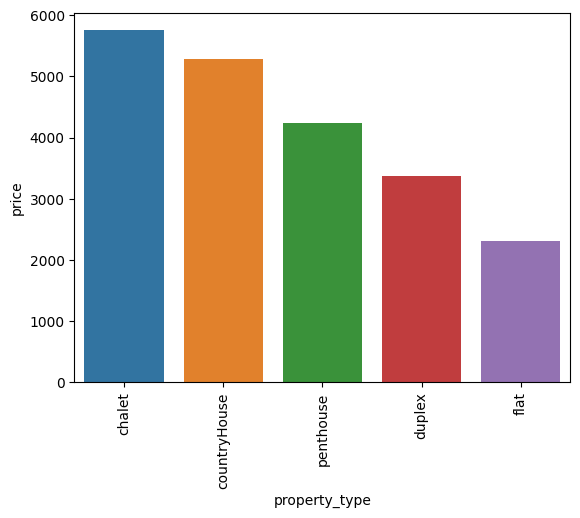

In [37]:
df_aux = df4[['property_type','price']].groupby( 'property_type').mean().reset_index().sort_values( by = 'price', ascending = False )

sns.barplot( data = df_aux, x = 'property_type', y = 'price' )
plt.xticks( rotation = 90 );

* Observação : O property_type tem uma influência no preço do imóvel.

### size

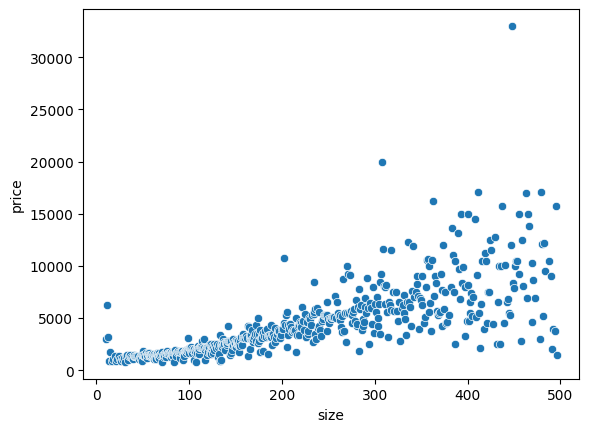

In [38]:
df_aux = df4[['size','price']].groupby( 'size' ).mean().reset_index().sort_values( by = 'size', ascending = True )

# remover outliers
df_aux = df_aux.loc[ df_aux['size'] < 500 , : ]

sns.scatterplot( data = df_aux, x = 'size', y = 'price' );

* Observação: O preço aumenta enquanto o tamanho do imóvel aumenta.

### rooms

<Axes: xlabel='rooms', ylabel='price'>

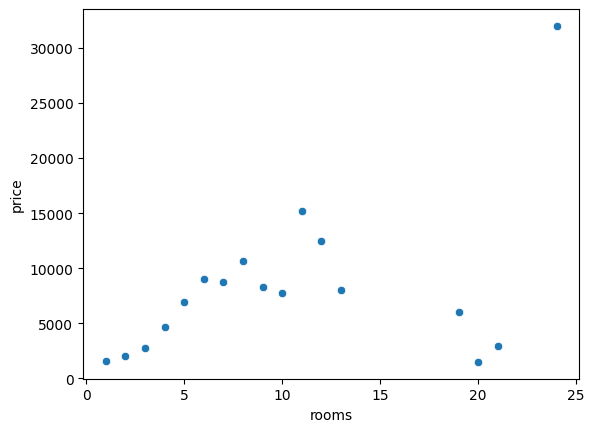

In [39]:
df_aux = df4[['rooms','price']].groupby( 'rooms' ).mean().reset_index().sort_values( by = 'rooms', ascending = True )

sns.scatterplot( data = df_aux, x = 'rooms', y = 'price' )

* Observação : Parece haver uma relação diretamente proporcional entre o número de quartos e o preço médio.

### bathrooms

<Axes: xlabel='bathrooms', ylabel='price'>

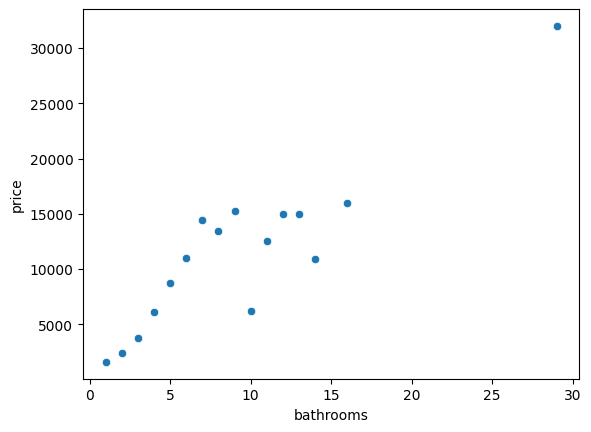

In [40]:
df_aux = df4[['bathrooms','price']].groupby( 'bathrooms' ).mean().reset_index()

sns.scatterplot( data = df_aux, x = 'bathrooms', y = 'price' )

* Observação : O preço médio aumenta a medida que aumenta o número de bathrooms. 

### address

,address,media_preco,n_amostras
3682,Rua do Cobre s/n,"80,000.00",1
3535,Rua das macieiras,"29,000.00",1
3504,Rua das Macieiras,"29,000.00",1
5066,"rua Pêro de Alenquer, 121","25,000.00",1
3949,Serralheiras de Cima,"24,000.00",1
...,...,...,...
990,Doutor Egas Moniz,500.00,1
2436,Rua Francisca de Meira,500.00,1
3464,Rua da Varandinha,450.00,1
2190,Rua DA VARANDINHA,450.00,1


C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


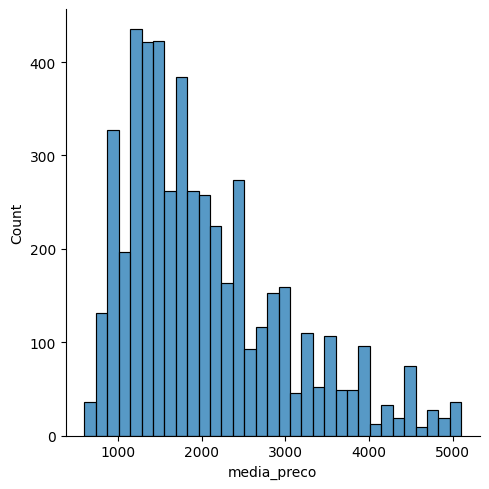

In [41]:
df_aux = ( df4[['address', 'price']].groupby('address').agg(
            media_preco = ( 'price', 'mean' ),
            n_amostras = ( 'address', 'count')
            ).reset_index()
         )

df_aux = df_aux.sort_values( by = 'media_preco', ascending = False )
display(df_aux)

q3 = df_aux['media_preco'].quantile(0.75)
q2 = df_aux['media_preco'].quantile(0.25)
di = q3 - q2
lim_sup = q3 + (1.5 * di)
lim_inf = q3 - (1.5 * di)

sns.displot( df_aux.loc[ (df_aux['media_preco'] >= lim_inf) & (df_aux['media_preco'] <= lim_sup), 'media_preco' ] )

* Observação : Como o endereço tem muitos valores únicos, avaliar a feature com o preço não nos fornece muitos insights. Em um próximo ciclo tentarei criar subconjutos do endereço.

### province

In [42]:
df_aux = df4[['province','price']].groupby( 'province' ).agg(
            media_preco = ( 'price', 'mean' ),
            n_amostras =  ( 'province', 'count' )

).reset_index()

df_aux

,province,media_preco,n_amostras
0,Lisboa,"2,956.81",13265
1,Santarém,"2,252.14",14
2,Setúbal,"1,895.25",1502


* Observação: Lisboa é a province com o maior preço médio e mais observações.

### municipality

In [43]:
df4[['municipality','price']].groupby( 'municipality' ).agg(
        media_preco = ( 'price', 'mean' ),
        n_amostras =  ( 'municipality', 'count' )

).reset_index().sort_values( by = 'media_preco', ascending =False )

,municipality,media_preco,n_amostras
55,Comporta,"18,000.00",1
14,Almargem do Bispo - Pêro Pinheiro - Montelavar,"6,292.11",19
118,Santo Estevão,"5,500.00",4
3,Alcabideche,"5,088.17",335
50,Cascais e Estoril,"5,020.80",2177
...,...,...,...
121,Sarilhos Grandes,800.00,2
91,Pegões,763.83,6
33,Benavente,562.50,4
20,Arranhó,550.00,1


* Conclusão: Uma média alta com poucas amostras podem nos levar a ilusão de que a munucipality tem considerável relevância no preço.

### district

In [44]:
df4[['district','price']].groupby( 'district' ).agg(
    preco_medio = ( 'price', 'mean' ),
    n_amostras = ( 'district', 'count' )
    ).reset_index().sort_values( by = 'preco_medio' , ascending = False )

,district,preco_medio,n_amostras
419,Zona Oeste,"14,408.33",6
280,Penha Longa - Linhó - Atrozela,"11,750.00",2
311,Quinta da Moura,"10,900.00",2
224,Malveira da Serra,"9,836.34",29
185,Fanqueiro - Bairro da Milharada,"9,716.67",6
...,...,...,...
263,Paivas,825.71,7
339,Salvaterra de Magos e Foros de Salvaterra,825.00,2
306,Quinta da Barroca,815.00,2
177,Estação - Colaride - Monte da Tapada,786.67,3


* Observação: Mesmo discurso para feature district, uma média alta com poucas observações podem distorcer a percepção de preço médio da região

In [45]:
mapa = folium.Map(location=[df4['latitude'].mean(), df4['longitude'].mean()], zoom_start=13)

# Lista de coordenadas
heat_data = [[row['latitude'], row['longitude']] for index, row in df4.iterrows()]

HeatMap(heat_data).add_to(mapa)


mapa.save('heatmap.html')


* Observação: Exportado mapa de calor em html para ver a densidade de preços através das features latitude e longitude.

### show_address

In [46]:
df_aux = df4[['show_address', 'price']].groupby( 'show_address' ).agg(
    media_preco = ( 'price', 'mean' ),
    n_amostras = ('show_address', 'count')

).reset_index()
df_aux

,show_address,media_preco,n_amostras
0,0.00,"2,940.97",12081
1,1.00,"2,433.51",2700


* Observação: A maioria das amostras não mostram o preço.

### distance

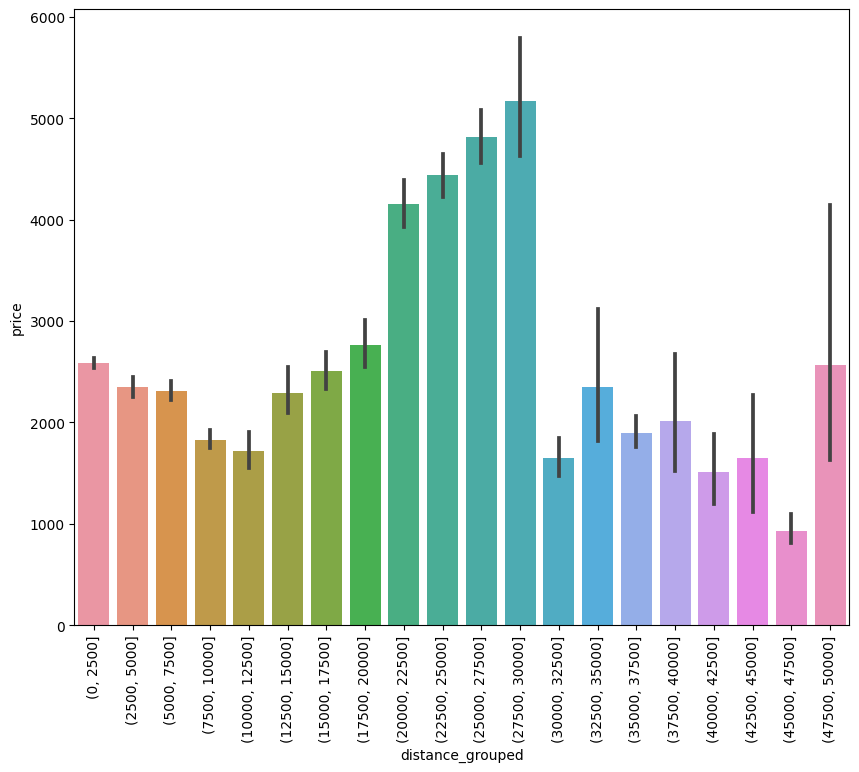

In [47]:
df_aux = df4[['distance','price','property_code']].groupby( 'distance' ).mean().reset_index()

max_dist = df_aux['distance'].max()

bins = np.arange( 0, int(max_dist) + 5000, 2500 )

df_aux['distance_grouped'] = pd.cut( df_aux['distance'], bins).astype( str )

# df_aux = df_aux.loc[ df_aux['price'] < 20000, : ]

plt.figure( figsize = (10,8) )
sns.barplot( data = df_aux, x = 'distance_grouped', y = 'price' )
plt.xticks( rotation = 90 );

In [48]:
df_aux_val = df4.loc[ (df4['distance'] >= 20000) &  (df4['distance'] <= 30000), : ]
df_aux_val[['distance','price','property_code']].groupby( ['distance','property_code'] ).agg(
            media_preco = ( 'price', 'sum' ),
            n_amostras = ('distance', 'count')

).reset_index().sort_values( by = 'media_preco', ascending = False ).head(20)

,distance,property_code,media_preco,n_amostras
2269,"25,782.00","32,519,205.00","80,000.00",1
2958,"27,879.00","32,757,649.00","33,000.00",1
2711,"26,631.00","32,670,350.00","33,000.00",1
2499,"26,246.00","32,376,756.00","29,000.00",1
2609,"26,428.00","32,576,817.00","29,000.00",1
1944,"25,057.00","32,095,174.00","29,000.00",1
1253,"23,405.00","32,609,522.00","27,500.00",1
1417,"23,756.00","32,695,135.00","27,500.00",1
1397,"23,692.00","32,792,590.00","25,000.00",1
1480,"24,033.00","33,234,298.00","25,000.00",1


In [49]:
# todos os outliers parecem ser chalet distantes do centro
df4.loc[ df4['property_code'].isin( [32519205, 32670350, 32757649] ) , : ]

,property_code,thumbnail,num_photos,floor,price,property_type,size,rooms,bathrooms,address,...,description_by_size,size_by_mean_province,num_photos_by_rooms,month,year,municipality_mean_price,district_mean_price,municipality_size,district_mean_size,province_mean_price
325,"32,519,205.00",1,32.00,0,"80,000.00",chalet,202.00,4.00,4.00,Rua do Cobre s/n,...,0.66,11.72,0.12,4,2023,"5,020.80","5,208.96",209.83,223.41,"2,956.81"
3569,"32,757,649.00",1,61.00,0,"33,000.00",chalet,"1,222.00",6.00,7.00,Quinta da Marinha,...,1.71,1.94,0.10,1,2024,"5,020.80","5,208.96",209.83,223.41,"2,956.81"
14485,"32,670,350.00",1,27.00,0,"33,000.00",chalet,448.00,5.00,6.00,Areia - Birre,...,0.61,5.29,0.19,7,2023,"5,020.80","5,208.96",209.83,223.41,"2,956.81"


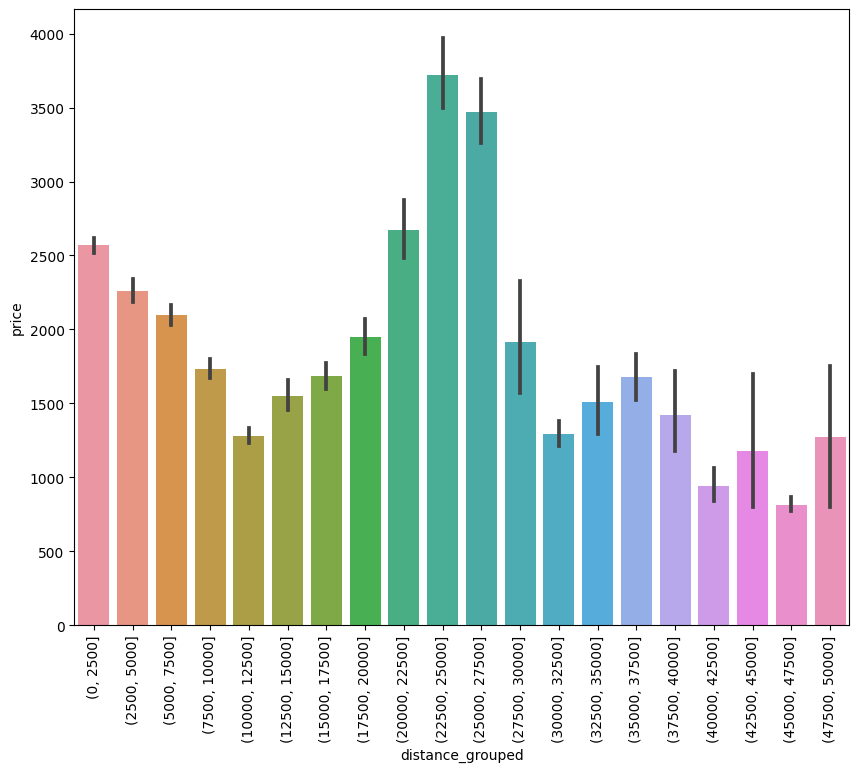

In [50]:
# refazendo a análise sem os chales

df_aux = df4.loc[ df4['property_type'] != 'chalet', : ]

df_aux = df_aux[['distance','price','property_code']].groupby( 'distance' ).mean().reset_index()

max_dist = df_aux['distance'].max()

bins = np.arange( 0, int(max_dist) + 5000, 2500 )

df_aux['distance_grouped'] = pd.cut( df_aux['distance'], bins).astype( str )

# df_aux = df_aux.loc[ df_aux['price'] < 20000, : ]

plt.figure( figsize = (10,8) )
sns.barplot( data = df_aux, x = 'distance_grouped', y = 'price' )
plt.xticks( rotation = 90 );

In [51]:
df_aux[(df_aux['distance'] >= 20000) & (df_aux['distance'] <= 30000)]

,distance,price,property_code,distance_grouped
6439,"20,003.00","3,500.00","32,557,843.00","(20000, 22500]"
6440,"20,005.00","1,350.00","32,852,916.00","(20000, 22500]"
6441,"20,019.00","1,050.00","32,593,889.00","(20000, 22500]"
6442,"20,022.00","3,200.00","33,087,254.00","(20000, 22500]"
6443,"20,026.00","1,800.00","32,412,277.00","(20000, 22500]"
...,...,...,...,...
8162,"29,928.00","1,300.00","32,751,300.00","(27500, 30000]"
8163,"29,969.00","1,350.00","32,656,030.00","(27500, 30000]"
8164,"29,971.00",600.00,"32,861,516.00","(27500, 30000]"
8165,"29,976.00","1,700.00","33,264,173.00","(27500, 30000]"


* Observação : As maiores médias de preço estão concentradas nas distâncias de 20 a 30 km do centro de Lisboa.(mesmo removendo os chalets)

### description

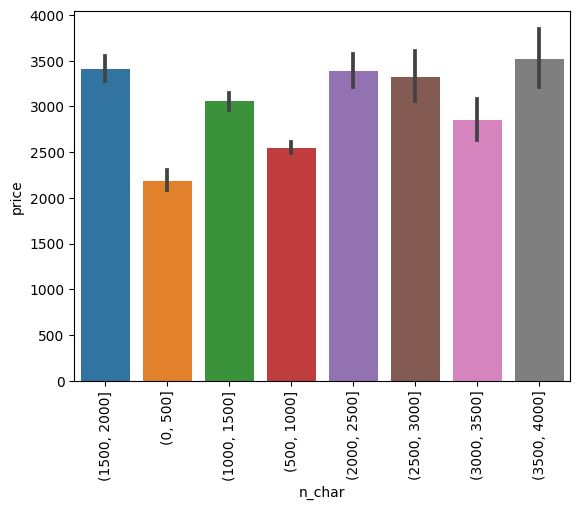

In [52]:
df_aux = df4[['description','price']].groupby( 'description' ).mean().reset_index() 

df_aux['description'] = df_aux['description'].apply( lambda x: len(x) ) 

max_char = df_aux['description'].max()

bins = np.arange( 0, int(max_dist) + 1000, 500 )

df_aux['n_char'] = pd.cut( df_aux['description'], bins).astype( str )


df_aux[['n_char','price']].groupby( 'n_char' ).mean().reset_index()

sns.barplot( data = df_aux, x = 'n_char', y = 'price' )
plt.xticks( rotation = 90 );

* Observação: Parece haver alguma relação entre as quantidades de caracteres e o preço.

 ## has_video

In [53]:
df4[['has_video','price']].groupby( 'has_video' ).agg(
    preco_medio = ( 'price', 'mean' ),
    n_amostras = ('has_video', 'count')
).reset_index()

,has_video,preco_medio,n_amostras
0,0.00,"2,689.25",10532
1,1.00,"3,242.45",4249


* Observação: Quando o imóvel tem vídeo o preço médio é um pouco maior.

## 4.1.1 -Check Distribution

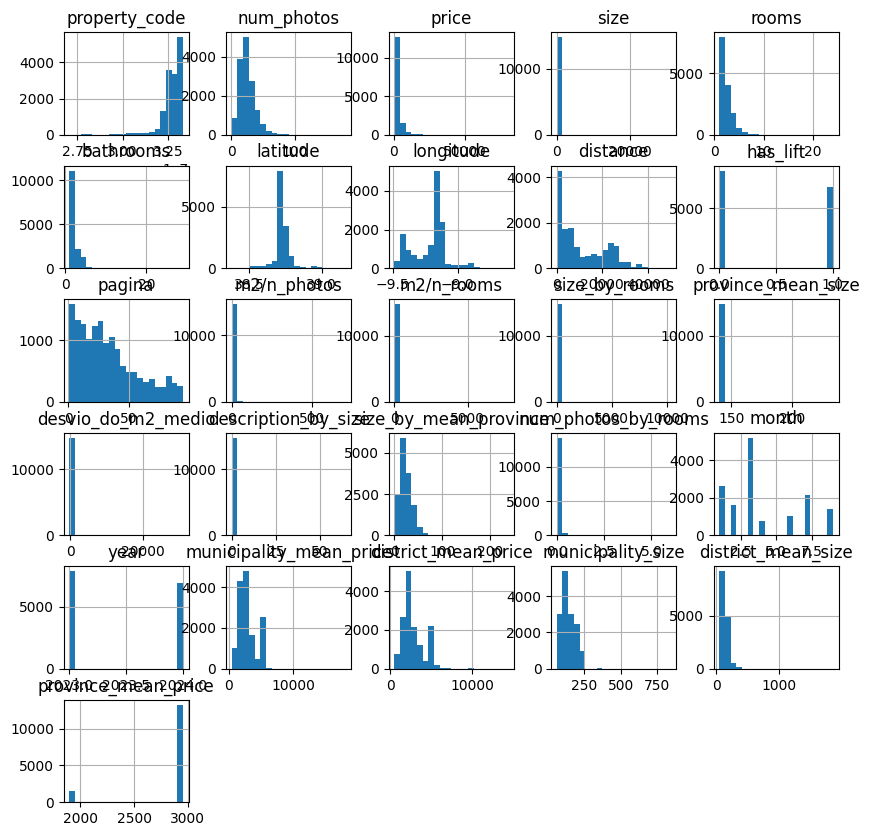

In [54]:
df4.hist(figsize=(10, 10), bins=20);


### 4.1.1 - Response Variable

C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


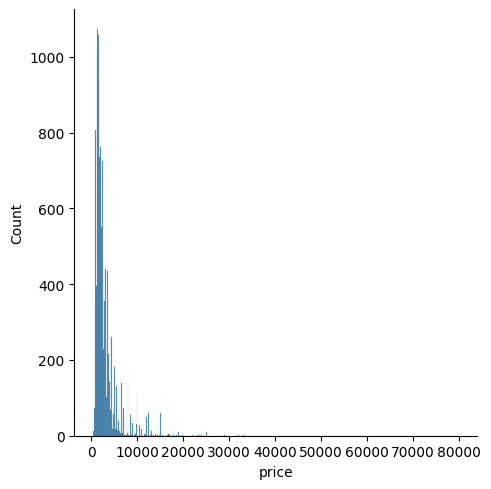

In [55]:
# variavael resposta normal
sns.displot( df4['price'] )

In [56]:
# função para remover outliers
def remove_outliers(df, coluna = None ,  keep_outliers = True ):
    
    if keep_outliers:
        print( 'Outliers mantidos' )
        return df
        
    else:
        # variavel resposta sem outliers
        df = remover_outliers( df4 , coluna )
        print('Outliers removidos')
        return df

In [57]:
# manter os outliers
df4 = remove_outliers( df4 )


Outliers mantidos


### 4.1.2 - Numerical Variable

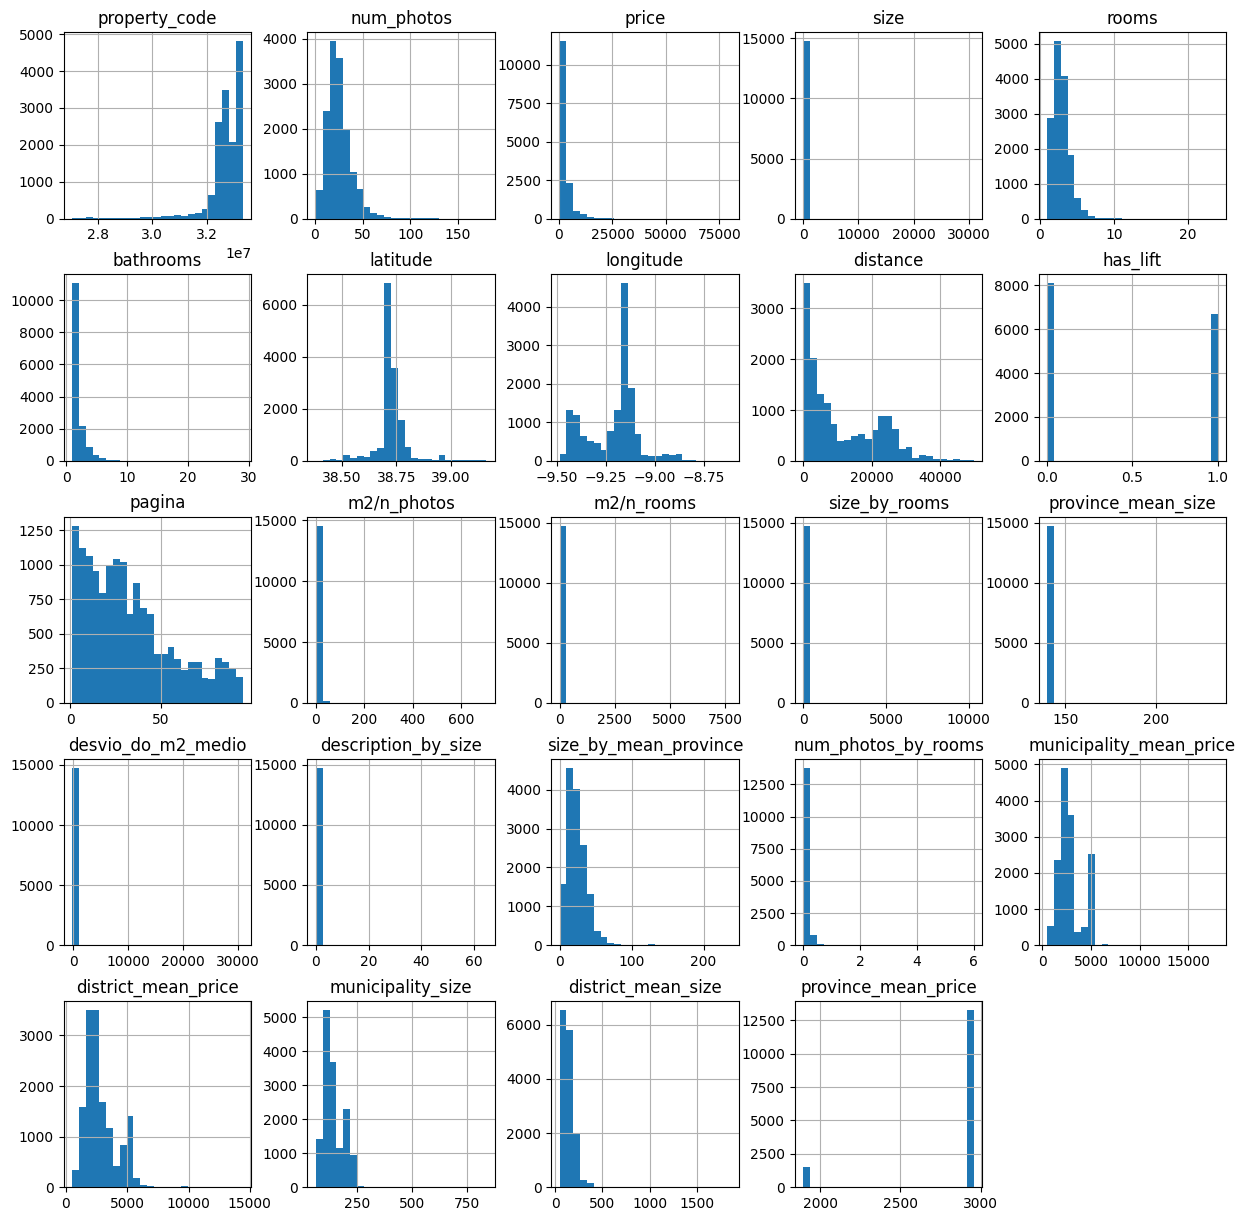

In [58]:
df4_num_attributes = df4.select_dtypes( include = ['int64','float64'] )
df4_num_attributes.hist( bins = 25, figsize=( 15,15 ) );

## 4.2. -  Análise Bivariada

### 4.2.1 - Correlação entre Atributos Numéricos

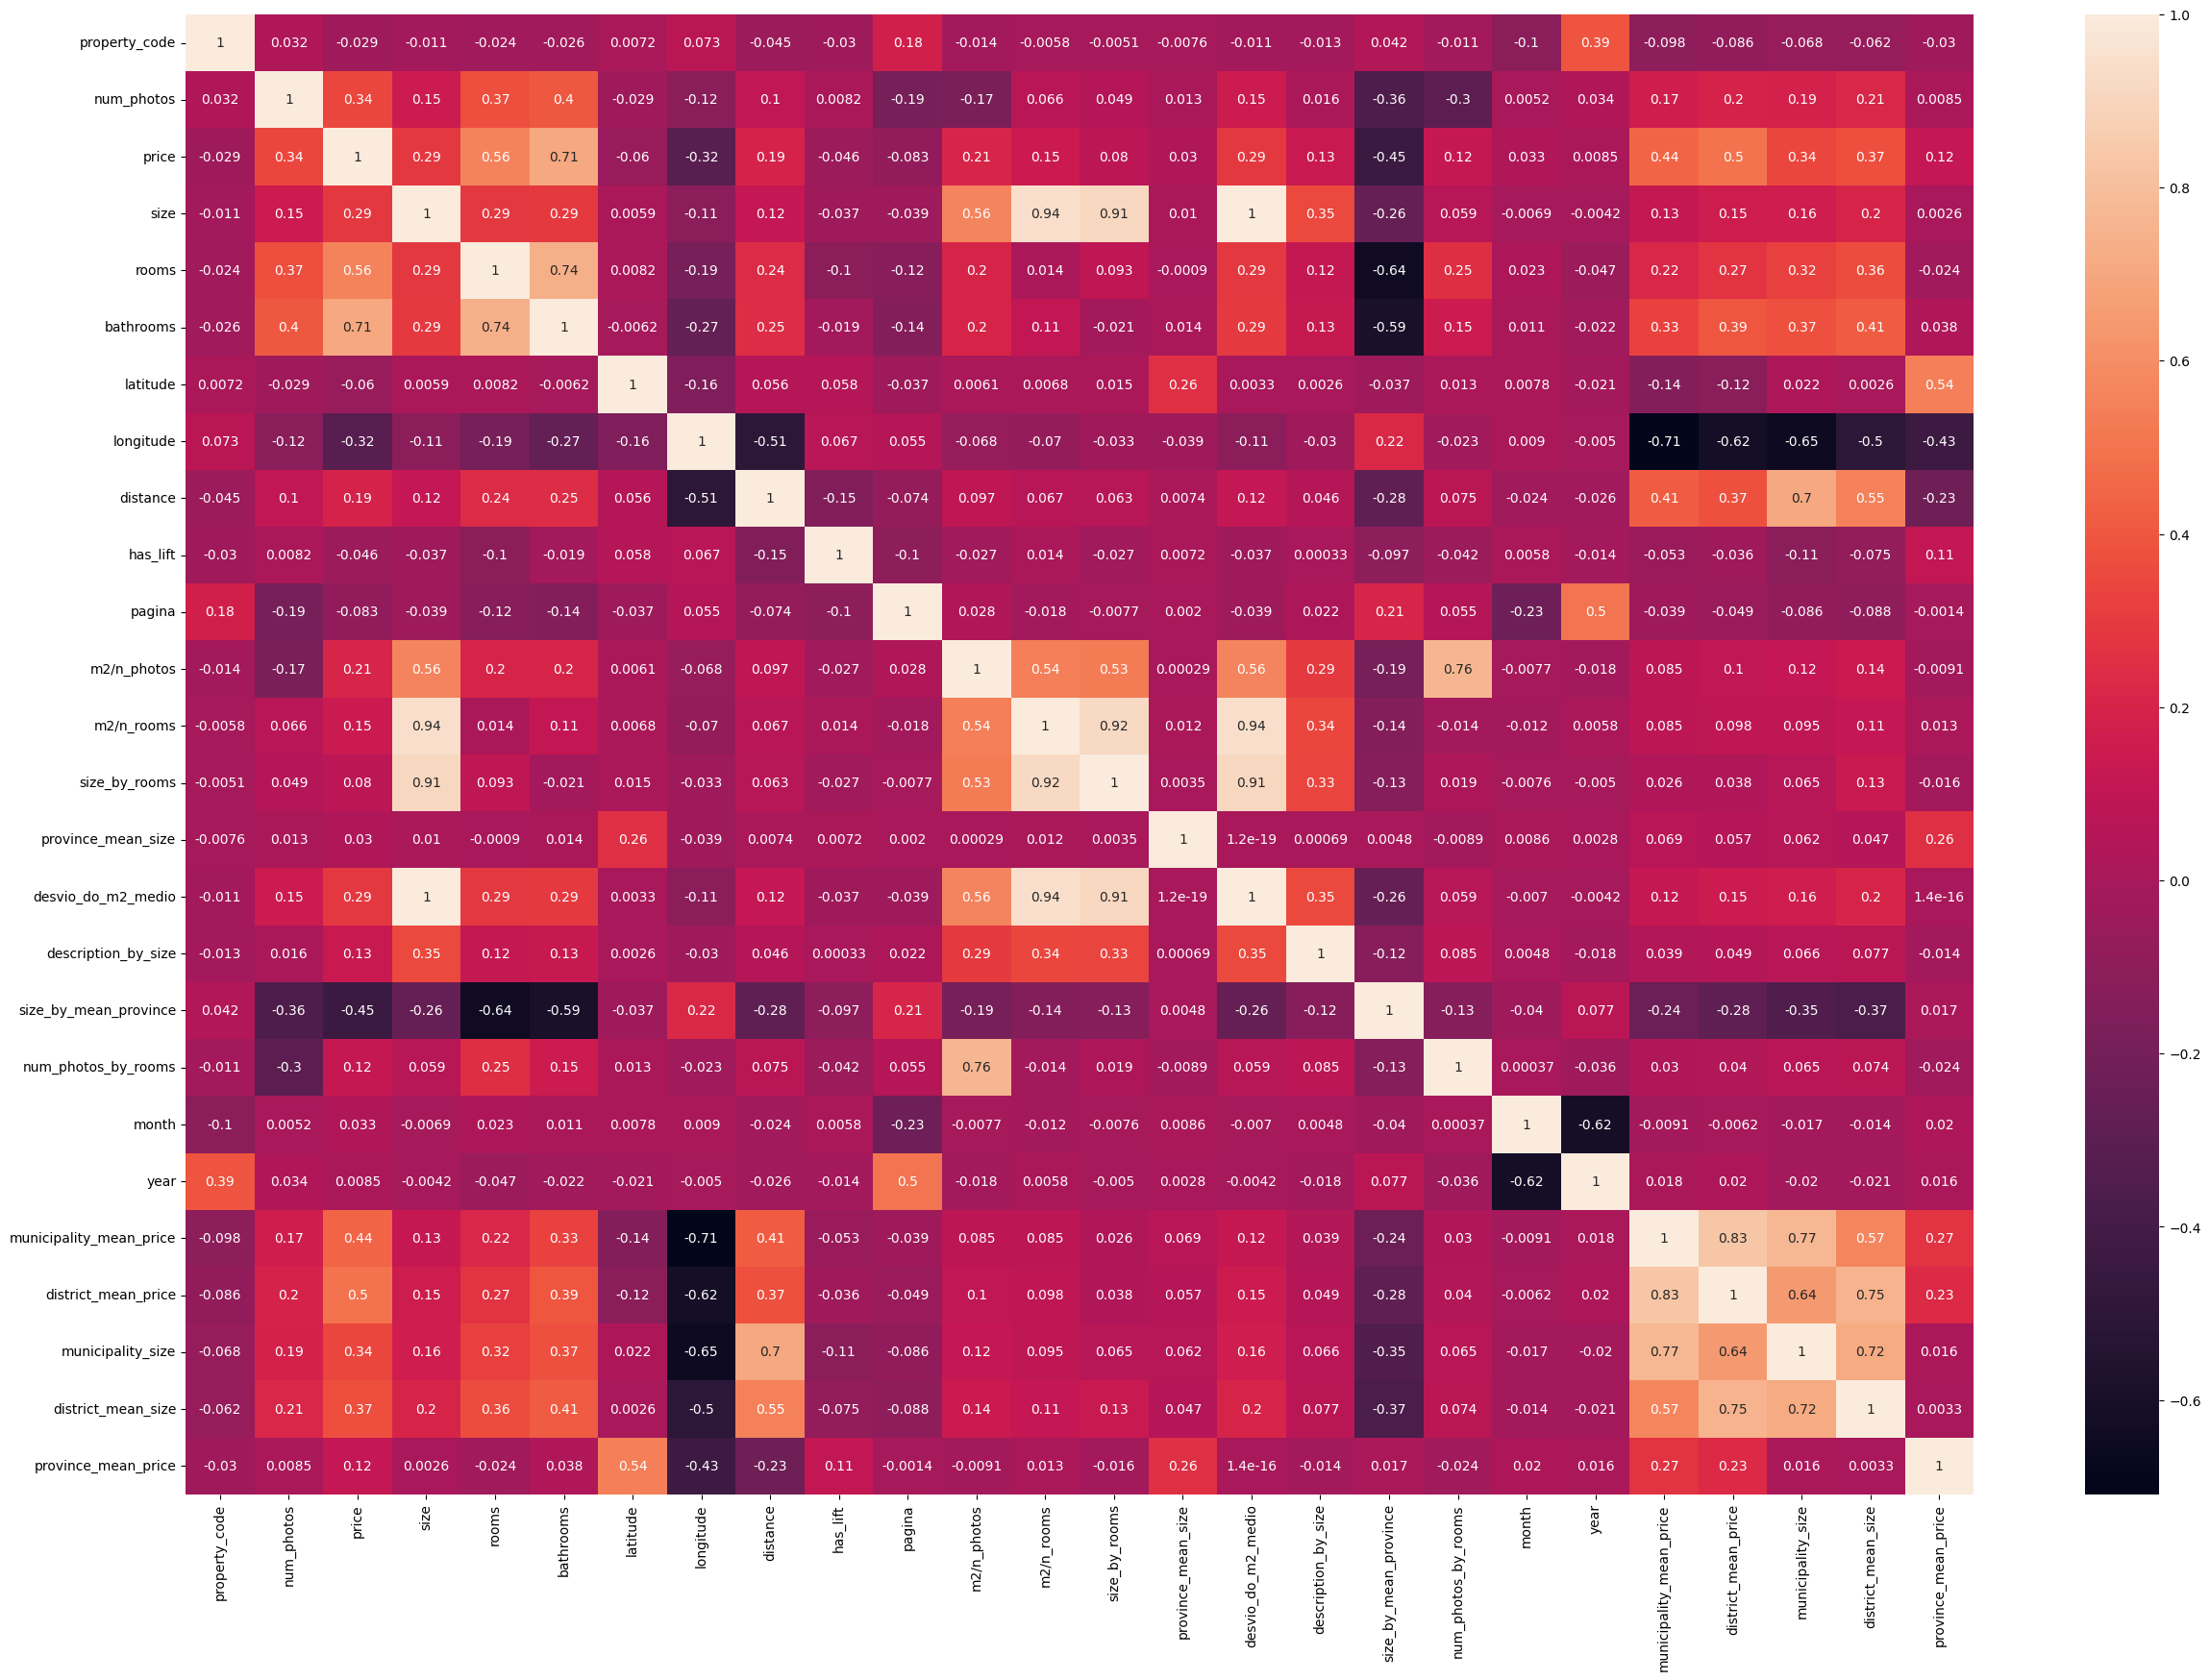

In [59]:
plt.figure( figsize = (30,20) )
correlation = df4.select_dtypes( exclude = ['object','datetime'] ).corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.2.2 - Excluir features altamente relacionadas 

In [60]:
columns = ['property_code',
'size_by_rooms',
'size_by_mean_province', 
'pagina',
'thumbnail',
'num_photos_by_rooms',
'municipality_mean_price',
'province_mean_price',
'district_mean_size',
'distance'
]

df4 = df4.drop( columns, axis = 1 )

### 4.2.2 - Correlação entre Atributos Categóricos

In [61]:
a = df4.select_dtypes( include = ['object'] ) # pego o df mais atualizado

# aplico a função cramer v nas variáveis categoricas
a1 = cramer_v( a['floor'] , a['floor'] )
a2 = cramer_v( a['floor'], a['property_type'] )
a3 = cramer_v( a['floor'], a['address'] )
a4 = cramer_v( a['floor'], a['province'] )
a5 = cramer_v( a['floor'], a['municipality'] )
a6 = cramer_v( a['floor'], a['district'] )
a7 = cramer_v( a['floor'], a['description'] )
a8 = cramer_v( a['floor'], a['status'] )
a9 = cramer_v( a['floor'], a['detailed_type'] )
a10 = cramer_v( a['floor'], a['suggested_texts'] )
a11 = cramer_v( a['floor'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a12= cramer_v( a['property_type'], a['floor'] )
a13= cramer_v( a['property_type'], a['property_type'] )
a14= cramer_v( a['property_type'], a['address'] )
a15= cramer_v( a['property_type'], a['province'] )
a16= cramer_v( a['property_type'], a['municipality'] )
a17= cramer_v( a['property_type'], a['district'] )
a18= cramer_v( a['property_type'], a['description'] )
a19= cramer_v( a['property_type'], a['status'] )
a20= cramer_v( a['property_type'], a['detailed_type'] )
a21=cramer_v(  a['property_type'], a['suggested_texts'] )
a22=cramer_v(  a['property_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a23= cramer_v( a['address'], a['floor'] )
a24= cramer_v( a['address'], a['property_type'] )
a25= cramer_v( a['address'], a['address'] )
a26= cramer_v( a['address'], a['province'] )
a27= cramer_v( a['address'], a['municipality'] )
a28= cramer_v( a['address'], a['district'] )
a29= cramer_v( a['address'], a['description'] )
a30= cramer_v( a['address'], a['status'] )
a31= cramer_v( a['address'], a['detailed_type'] )
a32=cramer_v(  a['address'], a['suggested_texts'] )
a33=cramer_v(  a['address'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a34= cramer_v( a['province'], a['floor'] )
a35= cramer_v( a['province'], a['property_type'] )
a36= cramer_v( a['province'], a['address'] )
a37= cramer_v( a['province'], a['province'] )
a38= cramer_v( a['province'], a['municipality'] )
a39= cramer_v( a['province'], a['district'] )
a40= cramer_v( a['province'], a['description'] )
a41= cramer_v( a['province'], a['status'] )
a42= cramer_v( a['province'], a['detailed_type'] )
a43=cramer_v(  a['province'], a['suggested_texts'] )
a44=cramer_v(  a['province'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a45= cramer_v( a['municipality'], a['floor'] )
a46= cramer_v( a['municipality'], a['property_type'] )
a47= cramer_v( a['municipality'], a['address'] )
a48= cramer_v( a['municipality'], a['province'] )
a49= cramer_v( a['municipality'], a['municipality'] )
a50= cramer_v( a['municipality'], a['district'] )
a51= cramer_v( a['municipality'], a['description'] )
a52= cramer_v( a['municipality'], a['status'] )
a53= cramer_v( a['municipality'], a['detailed_type'] )
a54=cramer_v(  a['municipality'], a['suggested_texts'] )
a55=cramer_v(  a['municipality'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a56= cramer_v( a['district'], a['floor'] )
a57= cramer_v( a['district'], a['property_type'] )
a58= cramer_v( a['district'], a['address'] )
a59= cramer_v( a['district'], a['province'] )
a60= cramer_v( a['district'], a['municipality'] )
a61= cramer_v( a['district'], a['district'] )
a62= cramer_v( a['district'], a['description'] )
a63= cramer_v( a['district'], a['status'] )
a64= cramer_v( a['district'], a['detailed_type'] )
a65=cramer_v(  a['district'], a['suggested_texts'] )
a66=cramer_v(  a['district'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a67= cramer_v( a['description'], a['floor'] )
a68= cramer_v( a['description'], a['property_type'] )
a69= cramer_v( a['description'], a['address'] )
a70= cramer_v( a['description'], a['province'] )
a71= cramer_v( a['description'], a['municipality'] )
a72= cramer_v( a['description'], a['district'] )
a73= cramer_v( a['description'], a['description'] )
a74= cramer_v( a['description'], a['status'] )
a75= cramer_v( a['description'], a['detailed_type'] )
a76=cramer_v(  a['description'], a['suggested_texts'] )
a77=cramer_v(  a['description'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a78= cramer_v( a['status'], a['floor'] )
a79= cramer_v( a['status'], a['property_type'] )
a80= cramer_v( a['status'], a['address'] )
a81= cramer_v( a['status'], a['province'] )
a82= cramer_v( a['status'], a['municipality'] )
a83= cramer_v( a['status'], a['district'] )
a84= cramer_v( a['status'], a['description'] )
a85= cramer_v( a['status'], a['status'] )
a86= cramer_v( a['status'], a['detailed_type'] )
a87=cramer_v(  a['status'], a['suggested_texts'] )
a88=cramer_v(  a['status'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a89= cramer_v( a['detailed_type'], a['floor'] )
a90= cramer_v( a['detailed_type'], a['property_type'] )
a91= cramer_v( a['detailed_type'], a['address'] )
a92= cramer_v( a['detailed_type'], a['province'] )
a93= cramer_v( a['detailed_type'], a['municipality'] )
a94= cramer_v( a['detailed_type'], a['district'] )
a95= cramer_v( a['detailed_type'], a['description'] )
a96= cramer_v( a['detailed_type'], a['status'] )
a97= cramer_v( a['detailed_type'], a['detailed_type'] )
a98=cramer_v(  a['detailed_type'], a['suggested_texts'] )
a99=cramer_v(  a['detailed_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a100= cramer_v( a['suggested_texts'], a['floor'] )
a101= cramer_v( a['suggested_texts'], a['property_type'] )
a102= cramer_v( a['suggested_texts'], a['address'] )
a103= cramer_v( a['suggested_texts'], a['province'] )
a104= cramer_v( a['suggested_texts'], a['municipality'] )
a105= cramer_v( a['suggested_texts'], a['district'] )
a106= cramer_v( a['suggested_texts'], a['description'] )
a107= cramer_v( a['suggested_texts'], a['status'] )
a108= cramer_v( a['suggested_texts'], a['detailed_type'] )
a109=cramer_v(  a['suggested_texts'], a['suggested_texts'] )
a110=cramer_v(  a['suggested_texts'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a111= cramer_v( a['parking_space'], a['floor'] )
a112= cramer_v( a['parking_space'], a['property_type'] )
a113= cramer_v( a['parking_space'], a['address'] )
a114= cramer_v( a['parking_space'], a['province'] )
a115= cramer_v( a['parking_space'], a['municipality'] )
a116= cramer_v( a['parking_space'], a['district'] )
a117= cramer_v( a['parking_space'], a['description'] )
a118= cramer_v( a['parking_space'], a['status'] )
a119= cramer_v( a['parking_space'], a['detailed_type'] )
a120=cramer_v(  a['parking_space'], a['suggested_texts'] )
a121=cramer_v(  a['parking_space'], a['parking_space'] )



d = pd.DataFrame( {'floor' : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11],
                   'property_type' : [a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22],
                   'address' : [a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33],
                   'province' : [a34,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44],
                   'municipality' : [a45,a46,a47,a48,a49,a50,a51,a52,a53,a54,a55],
                   'district' : [a56,a57,a58,a59,a60,a61,a62,a63,a64,a65,a66],
                   'description' : [a67,a68,a69,a70,a71,a72,a73,a74,a75,a76,a77],
                   'status' : [a78,a79,a80,a81,a82,a83,a84,a85,a86,a87,a88],
                   'detailed_type' : [a89,a90,a91,a92,a93,a94,a95,a96,a97,a98,a99],
                   'suggested_texts' : [a100,a101,a102,a103,a104,a105,a106,a107,a108,a109,a110],
                   'parking_space' : [a111,a112,a113,a114,a115,a116,a117,a118,a119,a120,a121]
              
              } )

d = d.set_index( d.columns )
d = d.drop( 'province', axis = 1 )

C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\3203194230.py:112: RuntimeWarn

In [62]:
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def calculate_cramer_v_for_dataframe(df, func=cramer_v):
    df_categorical = df.select_dtypes(include=['object', 'category'])
    columns = df_categorical.columns
    cramer_v_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    for col1 in df_categorical.columns:
        for col2 in df_categorical.columns:
            cramer_v_value = func(df_categorical[col1], df_categorical[col2])
            cramer_v_matrix.loc[col1, col2] = cramer_v_value
            
    return cramer_v_matrix

In [63]:
a = calculate_cramer_v_for_dataframe( df4 )

C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\543806490.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\543806490.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\543806490.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\543806490.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\543806490.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\543806490.py:10: RuntimeWarning: invalid valu

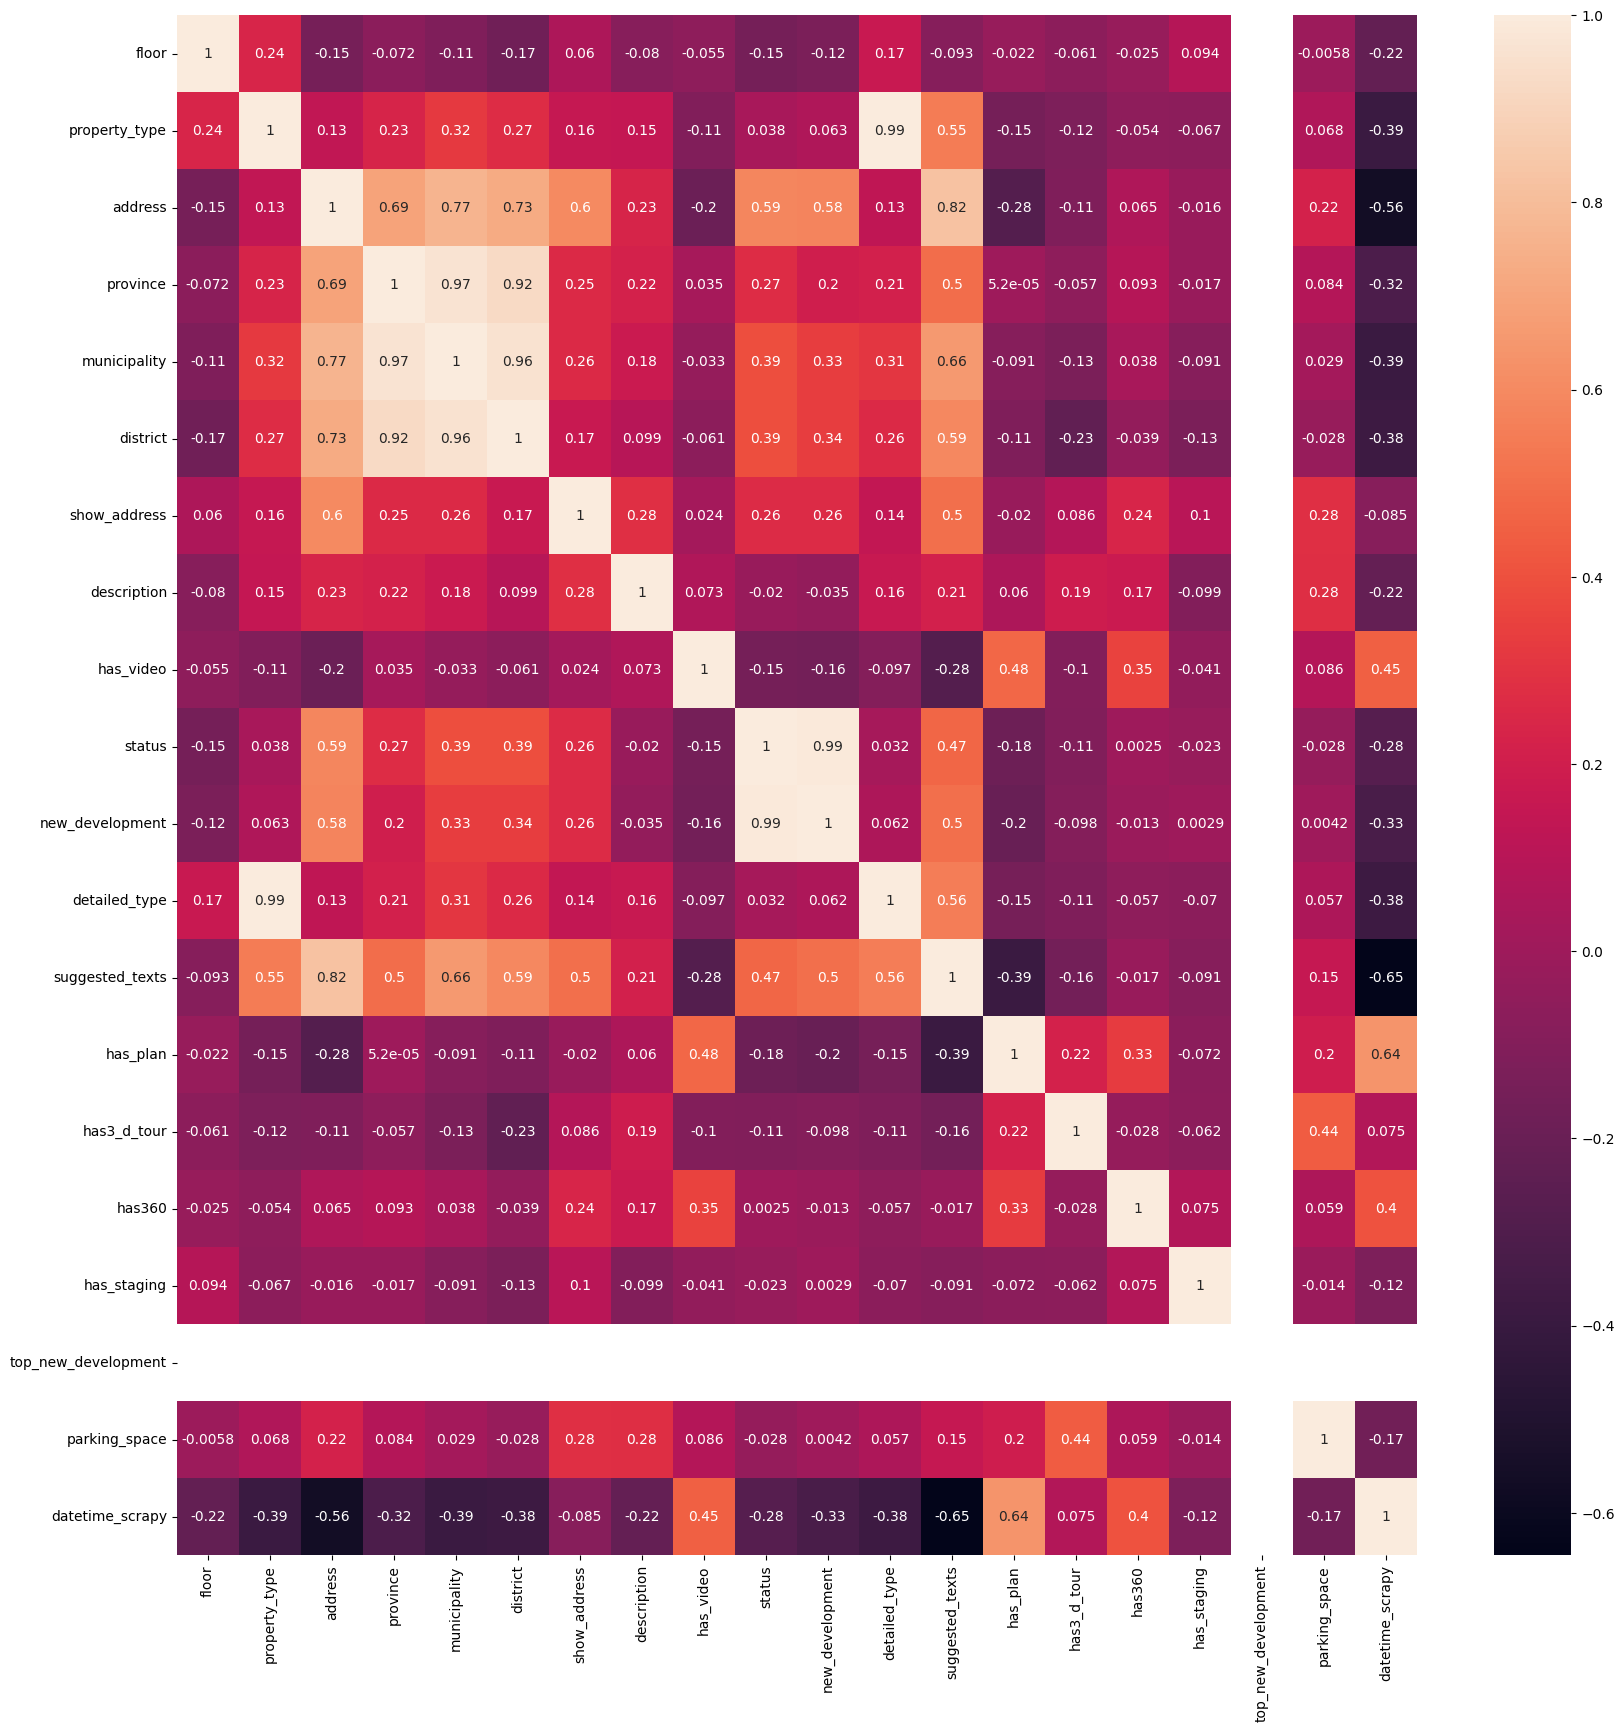

In [64]:
plt.figure(figsize=(20,20))
correlation = a.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.2.3 - Excluir features categóricas altamente relacionadas 

In [65]:
cat_columns =[ 'datetime_scrapy',
'detailed_type',
'address',
'municipality'
]

df4 = df4.drop( cat_columns, axis = 1 )

In [66]:
df4.head(1).T

,0
num_photos,9.00
floor,6
price,900.00
property_type,flat
size,65.00
rooms,1.00
bathrooms,1.00
province,Lisboa
district,Nova Carnaxide
latitude,38.72


# 5 - Data Preparation

In [67]:
df5 = df4.copy()

In [68]:
# # dividir entre treino e teste
# X = df4.drop( 'price', axis = 1 )
# y = df4['price']

# X_train_n, X_test_n , y_train_n , y_test_n = train_test_split(X, y, test_size=0.2, random_state=39)

# print('Total Shape {}'.format( df4.shape ))

# print('X_train shape {}'.format(X_train_n.shape) )
# print('y_train shape {}'.format(y_train_n.shape) )

# print('=='*50)

# print('X_test shape {}'.format(X_test_n.shape) )
# print('y_test shape {}'.format(y_test_n.shape) )

In [69]:
# # df treino
# df_treino = pd.concat( [X_train_n,y_train_n ], axis = 1 )

In [70]:
# # df teste
# df_teste = pd.concat( [X_test_n,y_test_n] , axis = 1)

In [71]:
# df5 = df_treino.copy()

C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


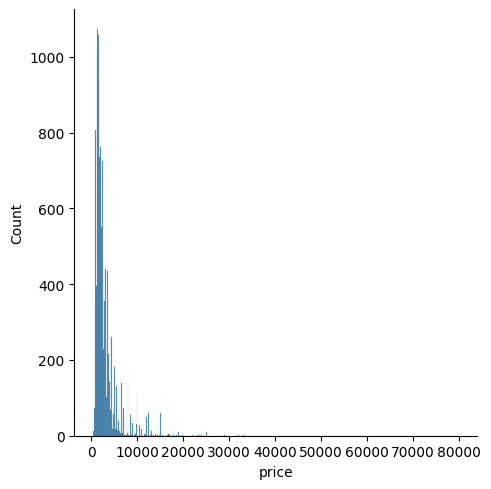

In [72]:
sns.displot( df5['price'] )

## 5.1. - Rescaling

## 5.1.2 Check Distribution

C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\4291806037.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['num_photos']  )
C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'num_photos')

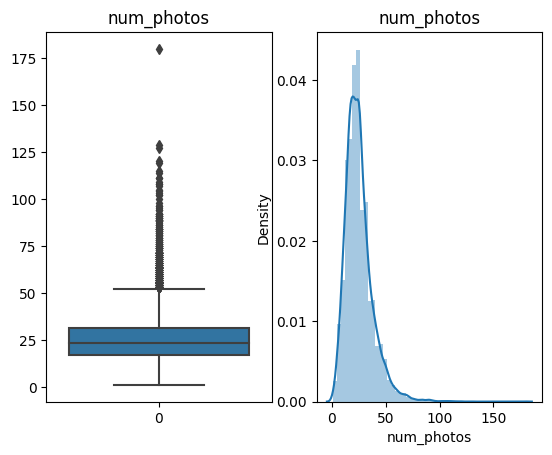

In [73]:
plt.subplot(1, 2, 1)
# num_photos
sns.boxplot( df5['num_photos'] )
plt.title( 'num_photos' )

plt.subplot(1, 2, 2)
# num_photos
sns.distplot( df5['num_photos']  )
plt.title( 'num_photos' )

C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\466936489.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['size']  )
C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'size')

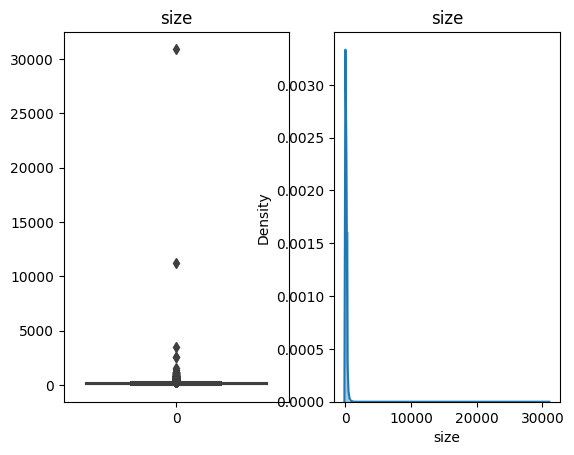

In [74]:
plt.subplot(1, 2, 1)
# size
sns.boxplot( df5['size'] )
plt.title( 'size' )

plt.subplot(1, 2, 2)
# size
sns.distplot( df5['size']  )
plt.title( 'size' )

C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\852878364.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['rooms']  )
C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'rooms')

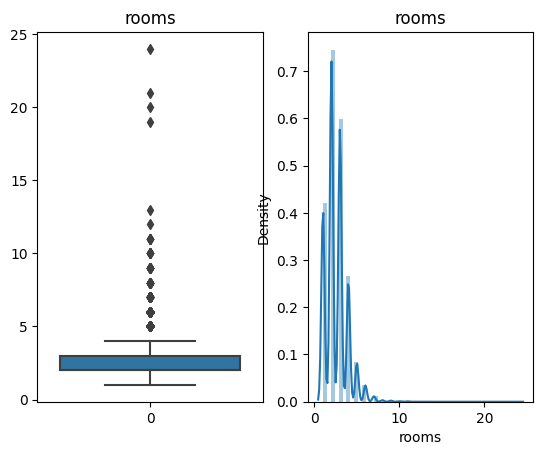

In [75]:
plt.subplot(1, 2, 1)
# rooms
sns.boxplot( df5['rooms'] )
plt.title( 'rooms' )

plt.subplot(1, 2, 2)
# rooms
sns.distplot( df5['rooms']  )
plt.title( 'rooms' )


C:\Users\oscar\AppData\Local\Temp\ipykernel_11152\3003154550.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['bathrooms']  )
C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'bathrooms')

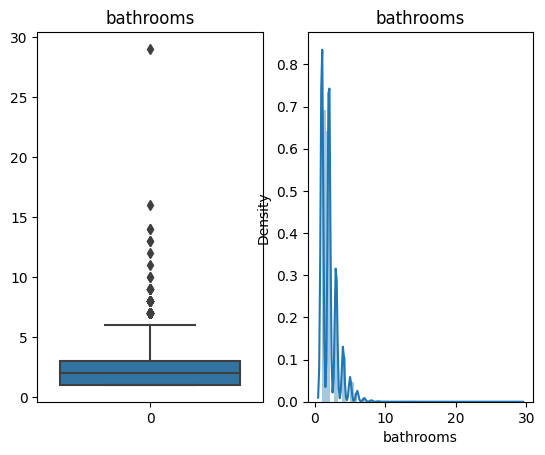

In [76]:
plt.subplot(1, 2, 1)
# bathrooms
sns.boxplot( df5['bathrooms'] )
plt.title( 'bathrooms' )

plt.subplot(1, 2, 2)
# rooms
sns.distplot( df5['bathrooms']  )
plt.title( 'bathrooms' )

KeyError: 'distance'

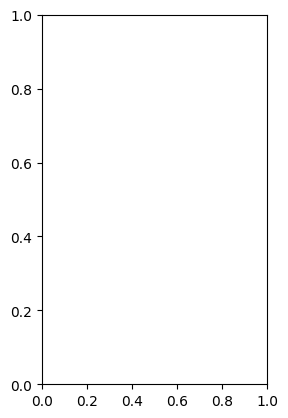

In [77]:
plt.subplot(1, 2, 1)
# distance
sns.boxplot( df5['distance'] )
plt.title( 'distance' )

plt.subplot(1, 2, 2)
# rooms
sns.distplot( df5['distance']  )
plt.title( 'distance' )

In [ ]:
def rescaling_data(df, rescale = False ):
    
    if rescale:
        rs = RobustScaler() # robusto com outliers
        mms = pp.MinMaxScaler() # desvio padrão pequeno e quando não ha distribuição gaussiana
        
#         # num_photos
#         rs_num_photos = RobustScaler() 
#         # num_photos
#         df['num_photos'] = rs_num_photos.fit_transform( df[['num_photos']].values )

        # floor
#         rs_floor = RobustScaler() 
#         # num_photos
#         df['floor'] = rs_floor.fit_transform( df[['floor']].values )
        
        # size
        rs_size = RobustScaler() 
        # size
        df['size'] = rs_size.fit_transform( df[['size']].values )
        
        # rooms
#         mms_rooms = pp.MinMaxScaler() 
#         # rooms
#         df['rooms'] = mms_rooms.fit_transform( df[['rooms']].values )
        
        # bathrooms
#         rs_bathrooms = RobustScaler() 
#         # bathrooms
#         df['bathrooms'] = rs_bathrooms.fit_transform( df[['bathrooms']].values )
        
        # distance
        rs_distance = RobustScaler()
        # distance
        df['distance'] = rs_distance.fit_transform( df[['distance']].values )
        
        
        
        print('Rescaled')
        
        return  df
    else:
        print('Not rescaled')
        
        return df

In [ ]:
df5 = rescaling_data( df5, rescale = True  )

In [ ]:
df5.isna().sum()

## 5.2 Encoding 

In [ ]:
def encoding( df ):
    
    # floor
    floor_mapping = {
        'ss': -1,   # subsolo
        'bj': 0,    # térreo
        'en': 0.5,  # entrepiso ou mezanino, considerado entre o térreo e o primeiro andar
        'st': 1.5   # sótão ou andar superior, considerado entre o primeiro andar e um segundo hipotético
    }

    df['floor'] = df['floor'].replace( floor_mapping ).astype( int )

    #property_type - label
    te_property_type = {'flat' : 0, 'duplex' : 1, 'chalet' : 2, 'studio': 3, 'penthouse': 4, 'countryHouse':5}
    #te_property_type = df.groupby( 'property_type' )['price'].mean()
    df['property_type'] = df['property_type'].map( te_property_type )
    pickle.dump(te_property_type,open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_property_type.pkl', 'wb' ) )
    
    # address - label
    freq_encoding_address = df['address'].value_counts(normalize=True)
    df['address'] = df['address'].map( freq_encoding_address )
    pickle.dump( freq_encoding_address, open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\freq_encoding_address.pkl', 'wb') )
                
    # province 
    te_province = df['province'].value_counts( )
    #te_province = df.groupby( 'province' )['price'].mean()
    df['province'] = df['province'].map( te_province )
    pickle.dump( te_province, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_province.pkl', 'wb' ) )
                
#     # municipality - label
#     te_municipality = df['municipality'].value_counts()
#     #te_municipality = df.groupby( 'municipality' )['price'].mean()
#     df['municipality'] = df['municipality'].map( te_municipality ).astype( 'float64' )
#     pickle.dump( te_municipality, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_municipality.pkl', 'wb' ) )            
    
    # municipality
    freq_encoding_municipality = df['municipality'].value_counts(normalize=True)
    df['municipality'] = df['municipality'].map( freq_encoding_municipality )
    

    # district - label
    te_district = df['district'].value_counts()
    #te_district = df.groupby( 'district' )['price'].mean()
    df['district'] = df['district'].map( te_district ).astype( 'float64' )
    pickle.dump( te_district, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_district.pkl', 'wb' ) )  
    # district
#     freq_encoding_district = df['district'].value_counts(normalize=True)
#     df['district'] = df['district'].map( freq_encoding_district )
    
    
    # Show address
    encoding = {True: 1 , False: 0}
    df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

    # description
    df['description'] = df['description'].apply( lambda x : len(x) )

    # has_video
    encoding = {True: 1 , False: 0}
    df['has_video'] = df['has_video'].map( encoding )

    # status
    te_status = {'good' : 1, 'newdevelopment' : 2 , 'renew' : 3}
    #te_status = df.groupby( 'status' )['price'].mean()
    df['status'] = df['status'].map( te_status ).astype( 'float64' )
    pickle.dump( te_status, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_status.pkl', 'wb' ) )  
    
    # label encoder status
    #status_encoder = LabelEncoder()
    #df['status'] = status_encoder.fit_transform( df['status'] )
    
    # new_development
    encoding = {True: 1 , False: 0}
    df['new_development'] = df['new_development'].map( encoding )

#     # detailed type - label
    le_detailed_type = LabelEncoder()
    
    df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
    df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
    df['detailed_type'] = le_detailed_type.fit_transform( df['detailed_type'] )
    pickle.dump( le_detailed_type, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\le_detailed_type.pkl', 'wb' ) ) 

    # suggested text
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

    # hasplan
    encoding = {True: 1 , False: 0}
    df['has_plan'] = df['has_plan'].map( encoding )

    # has3_d_tour
    encoding = {True: 1 , False: 0}
    df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

    # has360
    encoding = {True: 1 , False: 0}
    df['has360'] = df['has360'].map( encoding )

    # has_staging
    df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

    # top_new_development
    df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )
    
    #parking_space
    encoding = {True: 1 , False: 0}
    df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].map( encoding )
    
    df = df.drop( 'datetime_scrapy', axis = 1 )

    
    return df

In [ ]:
df5 = encoding( df5 )


In [ ]:
df5.head(1).T

# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()

## 6.1 Boruta

In [ ]:
def boruta_selection(df , use_boruta = False):
    
    if use_boruta:
    
        # training and test dataset for boruta
        X_train = df6.drop( ['price'] , axis= 1 ).values
        y_train = df6['price'].values.ravel()

        # instancia do Rf
        rf = RandomForestRegressor( n_jobs = -1 )

        # aplico o boruta
        boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train, y_train )
        
        # pega as colunas e coloca na variavel
        cols_selected = boruta.support_.tolist()

        # df boruta
        df_boruta = df6.drop('price', axis = 1).loc[ : , cols_selected]

        X_train = df6.drop( ['price'] , axis= 1 )
        cols_selected_boruta = X_train.loc[ : , cols_selected ]

        # cols not selected boruta
        cols_not_selected = list( np.setdiff1d( X_train.columns, cols_selected_boruta.columns ) )
        
        print('Boruta Used')
        
        return cols_selected_boruta , cols_not_selected
    
    else:
        print('Boruta skipped')
        return df

        


In [ ]:
df6, cols_not_sel = boruta_selection(df6, use_boruta = True)

In [ ]:
df6.columns

In [ ]:
df6 = df5[['bathrooms',
'size_by_mean_district',
'size',
'size_by_mean_province',
'description',
'district_mean_price',
'longitude',
'municipality',
'distance',
'description_by_size',
'latitude',
'size_by_rooms','price']]


In [ ]:
df6

# 7.0 Machine Learning

In [ ]:
# columns used for training
colunas_treino_modelo = df6.columns.to_list()

In [ ]:
df7 = df6.copy()

## 7.1 - Divisão entre treino e teste

In [ ]:
# # treino
# X_train = df7.drop( 'price', axis = 1 )
# y_train = df7['price']

In [ ]:
# # tratando os dados teste
# idealista = Idealista()

# df_teste_0 = idealista.rescaling_data( df_teste , rescale = False )
# df_teste_1 = idealista.encoding( df_teste_0 )


In [ ]:
# # separando os dados de teste
# X_test = df_teste_1[colunas_treino_modelo].drop('price', axis = 1 )
# y_test = df_teste_1['price']

In [ ]:
# dividir entre treino e teste
X = df7.drop( 'price', axis = 1 )
y = df7['price']

X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=39)

## 7.2 - Linear Regression

In [ ]:
# Criar um modelo de regressão linear
lr = LinearRegression()

# Treinar o modelo
lr.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = lr.predict( X_test )


In [ ]:
lr_metrics = ml_error( 'Linear Regression', y_test   , y_pred )
lr_metrics

## 7.2.1 - Linear Regression Cross Validation

In [ ]:
# cross validation
precision_scores = cross_val_score(lr, X_train, y_train, cv=100, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
cv_lr = np.round(mean_score,2)
lr_metrics_cv = pd.concat( [lr_metrics, pd.DataFrame( {'Cv Score' : [cv_lr]} ) ], axis = 1)
lr_metrics_cv

## 7.3 Lassso

In [ ]:
# model
lrr = Lasso( alpha = 0.01 ).fit( X_train , y_train )

# prediction
y_hat_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Lasso',  y_test  ,  y_hat_lrr  )
lrr_result

## 7.3.1 - Lasso Cross Validation

In [ ]:
# cross validation
precision_scores = cross_val_score(lrr, X_train, y_train, cv=20, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
cv_lasso = np.round( mean_score, 2)
lrr_result_cv = pd.concat( [lrr_result, pd.DataFrame( {'Cv Score' : [cv_lasso]} ) ], axis = 1) 
lrr_result_cv

## 7.4 Random Forest

In [ ]:
# model
rf = RandomForestRegressor( n_estimators = 100 , n_jobs = -1, random_state = 42  )

rf.fit( X_train , y_train )

# prediction
y_hat_rf = rf.predict(  X_test )

# 
rf_result = ml_error( 'Random Forest Regressor',  y_test  ,  y_hat_rf  )
rf_result

## 7.4 Random Forest Cross Validation

In [ ]:
# cross validation
precision_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring= 'neg_mean_absolute_error')

# mean score 
mean_score = np.mean( precision_scores )
rf_cv = np.round( mean_score, 2)
rf_result_cv = pd.concat( [rf_result, pd.DataFrame( {'Cv Score' : [rf_cv]} ) ], axis = 1) 
rf_result_cv

## 7.5 LGBM

In [ ]:
# Criar um conjunto de dados LightGBM a partir dos dados de treinamento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir parâmetros básicos
params = {
    'objective': 'regression',  # Regressão
    'metric': 'l2',  # Métrica de avaliação (erro quadrático médio)
    'boosting_type': 'gbdt',  # Tipo de aumento (gradient boosting)
}

# Treinar o modelo LightGBM
num_round = 100  # Número de iterações (árvores) de treinamento
bst = lgb.train(params, train_data, num_boost_round=num_round)

# Fazer previsões no conjunto de teste
y_pred_lgbm = bst.predict( X_test )

# performance
lgbm = ml_error( 'lgbm',  y_test  ,  y_pred_lgbm  )
lgbm


## 7.5.1 LGBM Cross Validation

In [ ]:
# Definir parâmetros básicos
params = {
    'objective': 'regression',  # Regressão
    'metric': 'r2',  # Usando R² como métrica de avaliação, se suportado pela sua versão do LightGBM
    'boosting_type': 'gbdt',  # Tipo de aumento (gradient boosting)
}

# Preparar o conjunto de dados LightGBM
lgb_data = lgb.Dataset(X_train, label=y_train)

# Número de iterações de treinamento
num_round = 100

# Configuração da validação cruzada
nfold = 10
seed = 42

kf = KFold(n_splits=nfold, random_state=seed, shuffle=True)

r2_scores = []

# Realizar a validação cruzada
for train_idx, val_idx in kf.split(X_train):
    X_train_fold = X_train.iloc[train_idx]  # Seleciona as linhas de treinamento
    y_train_fold = y_train.iloc[train_idx]  # Seleciona os rótulos de treinamento
    X_val_fold = X_train.iloc[val_idx]  # Seleciona as linhas de validação

    # Treinar o modelo LightGBM
    bst = lgb.train(params, lgb.Dataset(X_train_fold, label=y_train_fold), num_boost_round=num_round)

    # Fazer previsões no conjunto de validação
    y_pred = bst.predict(X_val_fold)

    # Calcular o R² score
    r2 = r2_score(y_train.iloc[val_idx], y_pred)
    r2_scores.append(r2)

# Mostrar a média dos R² scores
mean_r2 = np.mean(r2_scores)
lgbm_cv = pd.concat( [lgbm, pd.DataFrame( {'Cv Score' : [mean_r2]} ) ], axis = 1) 
lgbm_cv

## 7.6 XGBOOST

In [ ]:
# Criar um modelo XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)

# Treinar o modelo
model_xgb.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_xgb = model_xgb.predict( X_test )

# performance
xgb_performance = ml_error( 'xgb',  y_test  ,  y_pred_xgb  )
xgb_performance

## 7.6.1 XGBOOST Cross Validation

In [ ]:
# Realizar validação cruzada com 5 folds (ou o número que preferir) usando o R2 como métrica
scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='r2')

# Calcular a média dos coeficientes R2
mean_r2 = scores.mean()

# Imprimir o R2 médio
result_xgb = pd.concat( [xgb_performance, pd.DataFrame( {'Cv Score' : [mean_r2]} ) ], axis = 1) 

## 7.7 Resultados Modelos

In [ ]:
pd.concat( [lr_metrics_cv, lrr_result_cv, rf_result_cv , lgbm_cv , result_xgb] , axis = 0 ).sort_values( by = 'MAE'
 , ascending = True)

## 7.8 Resultados Cross Validation

## 8.1 Criando a classe Idealista

In [ ]:
class Idealista:
    def __init__( self ):
        
        self.df_region = pd.read_csv( 'datasets/df_region.csv' )
        self.home_path                    = r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings'

        self.te_status                    = pickle.load(open(os.path.join(self.home_path, 'te_status.pkl'), 'rb'))
        self.te_province                  = pickle.load(open(os.path.join(self.home_path,'te_province.pkl') , 'rb'))
        self.te_property_type             = pickle.load(open(os.path.join(self.home_path,'te_property_type.pkl'), 'rb'))
        self.te_municipality              = pickle.load(open(os.path.join(self.home_path,'te_municipality.pkl'), 'rb' ))
        self.te_district                  = pickle.load(open(os.path.join(self.home_path,'te_district.pkl'),'rb'))
        self.le_detailed_type             = pickle.load(open(os.path.join(self.home_path,'le_detailed_type.pkl'),'rb' ))
        self.freq_encoding_address        = pickle.load(open(os.path.join(self.home_path,'freq_encoding_address.pkl'), 'rb' ))
        
    def transform_data(self, df, colunas_irrelevantes ):

        cols_old = df.columns.to_list()

        # def função snake_case
        snake_case = lambda x: inflection.underscore( x )

        # defino as novas colunas
        cols_new = list(map( snake_case, cols_old )) 

        # atribuo as novas colunas ao df
        df.columns = cols_new

        # removo as linhas em branco que possam ter vindo na extração
        df = df.loc[~ df['property_code'].isna() , : ]

        # removo duplicadas
        df = df.drop_duplicates( subset= ['property_code'], keep = 'last' )

        # preencho os vazios
        df = fill_na( df )

        # deleto as colunaas irrelevantes
        df = delete_columns( df , colunas_irrelevantes )
   
        return df


#=======================================================================================================================#

    def feature_engineering(self, df , transform_data = False, merge_datasets = False   ):
        
        if transform_data == True and merge_datasets == False :
            
            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            print( 'Dados Transformados' )

            return df
        
    
        if merge_datasets == True and transform_data == False:
        
            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].median().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

#======================================================================================================================#

#             # calculando a média por 'province'
#             df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].median().reset_index().rename( columns = { 'price': 'province_mean_price' } )

#             # exportando para csv
#             # df2_province_mean_price.to_csv( 'datasets/province.csv' )

#             # acrescentando a coluna ao df2
#             df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'Datasets combinados com preços regioes' )

            return df
    
        if transform_data == True and merge_datasets == True:

            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

    # ======================================================================================================================#

#             # calculando a média por 'province'
#             df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

#             # exportando para csv
#             # df2_province_mean_price.to_csv( 'datasets/province.csv' )

#             # acrescentando a coluna ao df2
#             df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].mean().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'datasets combinados e dados transformados' )
        
            return df
        
        else:

            print( 'Nenhuma Transformação' )

            return df
            
#=======================================================================================================================#
    
    def filter_variables(self, df, filter_variables = False):
    
        if filter_variables:

            # Vou querer saber somente os preços na province de Lisboa
            df = df.loc[ df['province'] == 'Lisboa' , :  ]

            # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
            df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]

            print('Variavies filtradas')

            return df

        else:

            print('Variavies não filtradas')

            return df

#=======================================================================================================================#

    # função para remover outliers
    def remove_outliers(self, df, coluna = None ,  keep_outliers = True ):

        if keep_outliers:
            print( 'Outliers mantidos' )
            return df

        else:
            # variavel resposta sem outliers
            df = remover_outliers( df4 , coluna )
            print('Outliers removidos')
            return df

#=======================================================================================================================#
    
    def rescaling_data(self, df, rescale = False ):

        if rescale:
            rs = RobustScaler() # robusto com outliers
            mms = pp.MinMaxScaler() # desvio padrão pequeno e quando não ha distribuição gaussiana

    #         # num_photos
    #         rs_num_photos = RobustScaler() 
    #         # num_photos
    #         df['num_photos'] = rs_num_photos.fit_transform( df[['num_photos']].values )

            # floor
#             rs_floor = RobustScaler() 
#             # num_photos
#             df['floor'] = rs_floor.fit_transform( df[['floor']].values )

            # size
            rs_size = RobustScaler() 
            # size
            df['size'] = rs_size.fit_transform( df[['size']].values )

            # rooms
    #         mms_rooms = pp.MinMaxScaler() 
    #         # rooms
    #         df['rooms'] = mms_rooms.fit_transform( df[['rooms']].values )

            # bathrooms
    #         rs_bathrooms = RobustScaler() 
    #         # bathrooms
    #         df['bathrooms'] = rs_bathrooms.fit_transform( df[['bathrooms']].values )

            # distance
            rs_distance = RobustScaler()
            # distance
            df['distance'] = rs_distance.fit_transform( df[['distance']].values )



            print('Rescaled')

            return  df
        else:
            print('Not rescaled')

            return df

#=======================================================================================================================#

    def encoding( self, df ):

        # floor - substituo os andares com letras
        df['floor'] = df['floor'].replace( ['bj','st','ss','en'], 0 )
        # transformo em inteiros
        df['floor'] = df['floor'].astype( 'int64' )

        #property_type - label
        te_property_type = {'flat' : 0, 'duplex' : 1, 'chalet' : 2, 'studio': 3, 'penthouse': 4, 'countryHouse':5}
        #te_property_type = df.groupby( 'property_type' )['price'].mean()
        df['property_type'] = df['property_type'].map( te_property_type )
        pickle.dump(te_property_type,open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_property_type.pkl', 'wb' ) )

        # address - label
        freq_encoding_address = df['address'].value_counts(normalize=True)
        df['address'] = df['address'].map( freq_encoding_address )
        pickle.dump( freq_encoding_address, open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\freq_encoding_address.pkl', 'wb') )

        # province 
        te_province = df['province'].value_counts( )
        #te_province = df.groupby( 'province' )['price'].mean()
        df['province'] = df['province'].map( te_province )
        pickle.dump( te_province, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_province.pkl', 'wb' ) )

        # municipality - label
        te_municipality = df['municipality'].value_counts()
        #te_municipality = df.groupby( 'municipality' )['price'].mean()
        df['municipality'] = df['municipality'].map( te_municipality ).astype( 'float64' )
        pickle.dump( te_municipality, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_municipality.pkl', 'wb' ) )            

        # municipality
    #     freq_encoding_municipality = df['municipality'].value_counts(normalize=True)
    #     df['municipality'] = df['municipality'].map( freq_encoding_municipality )


        # district - label
        te_district = df['district'].value_counts()
        #te_district = df.groupby( 'district' )['price'].mean()
        df['district'] = df['district'].map( te_district ).astype( 'float64' )
        pickle.dump( te_district, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_district.pkl', 'wb' ) )  
        # district
    #     freq_encoding_district = df['district'].value_counts(normalize=True)
    #     df['district'] = df['district'].map( freq_encoding_district )


        # Show address
        encoding = {True: 1 , False: 0}
        df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

        # description
        df['description'] = df['description'].apply( lambda x : len(x) )

        # has_video
        encoding = {True: 1 , False: 0}
        df['has_video'] = df['has_video'].map( encoding )

        # status
        te_status = {'good' : 1, 'newdevelopment' : 2 , 'renew' : 3}
        #te_status = df.groupby( 'status' )['price'].mean()
        df['status'] = df['status'].map( te_status ).astype( 'float64' )
        pickle.dump( te_status, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_status.pkl', 'wb' ) )  

        # label encoder status
        #status_encoder = LabelEncoder()
        #df['status'] = status_encoder.fit_transform( df['status'] )

        # new_development
        encoding = {True: 1 , False: 0}
        df['new_development'] = df['new_development'].map( encoding )

        # detailed type - label
        le_detailed_type = LabelEncoder()

        df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
        df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
        df['detailed_type'] = le_detailed_type.fit_transform( df['detailed_type'] )
        pickle.dump( le_detailed_type, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\le_detailed_type.pkl', 'wb' ) ) 

        # suggested text
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

        # hasplan
        encoding = {True: 1 , False: 0}
        df['has_plan'] = df['has_plan'].map( encoding )

        # has3_d_tour
        encoding = {True: 1 , False: 0}
        df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

        # has360
        encoding = {True: 1 , False: 0}
        df['has360'] = df['has360'].map( encoding )

        # has_staging
        df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

        # top_new_development
        df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )

        #parking_space
        encoding = {True: 1 , False: 0}
        df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].map( encoding )

        df = df.fillna(0)    

        return df


    def predicoes(self, df , model ):
        
        # drop price
        X = df.drop( 'price', axis = 1 )
        
        y_hat_final = model.predict( X )
        
        df['pred'] = y_hat_final
        
        return df
        


In [ ]:
a = df3.loc[  df3['address'].isin( ['Moscavide e Portela'] ), : ].head()[cols]


In [ ]:
a

In [ ]:
b = test_prediction( a, bst )


In [ ]:
b

In [ ]:
df_raw.district.unique()

## 8.1.2 Feature Importances

In [ ]:
# Obter importâncias das features
importances = rf.feature_importances_

# Converter as importâncias em um DataFrame para facilitar a visualização
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Ordenar as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

ax = sns.barplot(data = features_df, x = 'Feature', y = 'Importance')

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
features_df


## 8.1.3 Test com Dados Inseridos Manualmente

In [ ]:
# vejo a estrutura de uma linha
# df_teste.loc[ 16640 ]

In [ ]:
# teste com um dados de um imóvel conhecido
test = {
'property_code': 0,
'thumbnail': 0,
'num_photos': 5,
'floor': 1,
'price' : 0,
'property_type': 'flat',
'operation': 'rent',
'size': 30,
'exterior': True,
'rooms': 1 ,
'bathrooms':1,
'address' : 'Moscavide e Portela',
'province': 'Lisboa',
'municipality': 'Moscavide e Portela',
'district' : 'Moscavide e Portela',
'country': 'PT',
'latitude' : 38.775101412019715,
'longitude': -9.104655113802375,
'show_address': True,
'url': 'www.imoveisportugal.com',
'distance': 10000,
'description' : 'Apartamento localizado na rua 1º de Maio. T1 remodelado, em frente ao metro, próximo a supermercados e ao parque das nações. 3 cauções adiantadas ou 2 fiadores',
'has_video' : False,
'status' : 'good',
'new_development' : False,
'has_lift': 1,
'price_by_area' : 0,
'detailed_type': str({'typology': 'flat'}),
'suggested_texts' : str({'subtitle': 'Moscavide e Portela, Loures', 'title': 'Apartamento'}),
'has_plan' : True,
'has3_d_tour': False,
'has360' : False,
'has_staging' : False,
'top_new_development' : False,
'super_top_highlight' : False,
'parking_space' : '0',
'external_reference':0,
'labels' : 0,                                                                 
'neighborhood': 0,                                                         
'pagina' : 0,                                                                  
'datetime_scrapy':  pd.to_datetime('2024-02-05 10:18:37'),                                         
'new_development_finished': 0,                                                  
'highlight' : 0 

}

df_pred_test = pd.DataFrame( [test] )


In [ ]:
df_pred_test

In [ ]:
def test_prediction( df , model ):
    # instancia a classe Idealista
    idealista_1 = Idealista()

    # limpando os dados
    df1_val = idealista_1.transform_data( df , colunas_irrelevantes )

    # feature engineering
    df2_val = idealista_1.feature_engineering( df1_val , transform_data = True, merge_datasets = True  )

    # filtrar variáveis
    df3_val = idealista_1.filter_variables( df2_val )

    # reomver outliers
    df4_val = idealista_1.remove_outliers( df3_val )

    # reescalar dados
    df5_val = idealista_1.rescaling_data( df4_val, rescale = True )

    # encodar dados
    df6_val = idealista_1.encoding( df5_val )
    
    df6_val =df6_val[colunas_treino_modelo,'price']

    df6_val = df6_val.fillna( 0 )
    
    # predicoes
    df7_val = idealista_1.predicoes( df6_val ,model )
    
    return df6_val

In [ ]:
a = test_prediction( df_pred_test , rf )
print(a.isnull().sum())
a.T

In [ ]:
# Obter importâncias das features
importances = rf.feature_importances_

# Converter as importâncias em um DataFrame para facilitar a visualização
features_df = pd.DataFrame({
    'Feature': a.drop(['price','pred'], axis = 1).columns,
    'Importance': importances
})

# Ordenar as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

ax = sns.barplot(data = features_df, x = 'Feature', y = 'Importance')

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
len(df_pred_test.columns)

In [ ]:
df_val = clean_data( df_val )

In [ ]:
df_val[['price','pred']]

In [ ]:
def clean_data( df ):    

    transform = Idealista()

    df1 = transform.transform_data( df , colunas_irrelevantes )
    df2 = transform.feature_engineering( df1, transform_data = True )
    df3 = transform.filter_variables( df2 )
    df4 = transform.remove_outliers( df3 )
    df5 = transform.rescaling_data( df4, rescale = True )
    df6 = transform.encoding( df5 )
   

    return df6



In [ ]:
y_hat = rf.predict( df_val.drop( 'price', axis = 1 ) )

ml_error( 'Rf', df_val['price'], y_hat )